In [1]:
%matplotlib inline
from IPython.display import display
import ast

import pandas as pd
pd.set_option('max_colwidth',100)
import numpy as np
import matplotlib as mpl
mpl.rcParams['legend.numpoints'] = 1
mpl.rcParams['legend.scatterpoints'] = 1
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import statsmodels.api as sm
from scipy import stats

import collections
from itertools import compress

In [2]:
whichyear='both' 
suff = 'V2_50pred_julaug_10allowed'
letters=['a','b','c','d','e','f','g','h','i','j','k','l','m']
modelnames=['$ln(C_{chla})$','$ln(B_{cyano})$','$ln(C_{mc})$','$ln(C_{TN})$','$ln(C_{TP})$']
legnames=[
    'Chlorophyll-a concentration [μg/L]','Cyanobacterial biovolume [μm3/mL]',
    'Microcystin concentration [μg/L]',
    'Total Nitrogen concentration [μg/L]','Total Phosphorus concentration [μg/L]'
]
legnames_short=[
    '$C_{chla} \  [\mu g/L]$',
    '$B_{cyano} \  [\mu m^3/mL]$',
    '$C_{mc} \  [\mu g/L]$',
    '$C_{TN} \  [\mu g/L]$',
    '$C_{TP} \  [\mu g/L]$'
]

df_chla = pd.DataFrame.from_csv('df_chla_{}_{}.csv'.format(whichyear,suff))
df_cybv = pd.DataFrame.from_csv('df_cybv_{}_{}.csv'.format(whichyear,suff))
df_mic = pd.DataFrame.from_csv('df_mic_{}_{}.csv'.format(whichyear,suff))
df_clean = pd.DataFrame.from_csv('df_clean_{}_{}.csv'.format(whichyear,suff))
for df in [df_clean,df_mic,df_chla,df_cybv]:
    df.reset_index(inplace=True)
    df.set_index(['SITE_ID','VISIT_NO'],inplace=True)
    
dict_meta = {
    'chla' :[df_chla,'chla_log'],
    'cybv' :[df_cybv,'cybv_log'],
    'mic'  :[df_mic,'mic_log_above_dl'],
    'tn'   :[df_clean,'TN_tn_log'],
    'tp'   :[df_clean,'TP_tp_log'],
}

#set up renaming of variables 
df_names = pd.DataFrame.from_csv('bma/bma_{}_{}_{}.csv'.format('chla',whichyear,'V2_60pred_julaug'))
allvar_names = df_names['pred_var'].sort_values().values
allvar_renames = allvar_names.copy()
allvar_disp = [
    '$DOY$',
    '$P_{p>0.90}$','$P_{JJA,p>0.90}$','$P_{MAM,p>0.90}$',
    '$P_{p>0.95}$','$P_{JJA,p>0.95}$','$P_{MAM,p>0.95}$',
    '$P_{p>0.99}$','$P_{JJA,p>0.99}$','$P_{MAM,p>0.99}$',
    '$Mon$',
    '$ln(C_{TN})$','$C_{TN}$',
    '$ln(C_{TP})$','$C_{TP}$',
    '$T_{air,annual}$','$T_{air,JJA}$','$T_{air,MAM}$',
    '$A$','$ln(A)}',
    '$NANI$','$FNI$','$ln(FNI)$','$asinh(NANI)$',
    '$NAPI$','$FPI$','$ln(FPI)$','$asinh(NAPI)$',
    '$D$','$ln(D)$',
    'N fertilizer x Extreme precip annual (90th)',
    'N fertilizer x Extreme precip annual (95th)',
    'N fertilizer x Extreme precip annual (99th)',
    'N fertilizer x Total precip annual','N fertilizer x Total precip annual (log)',
    'P fertilizer x Extreme precip annual (90th)',
    'P fertilizer x Extreme precip annual (95th)',
    'P fertilizer x Extreme precip annual (99th)',
    'P fertilizer x Total precip annual','P fertilizer x Total precip annual (log)',
    '$Q_{TN}$','$ln(Q_{TN})$',
    '$Lat$','$Lon$',
    '$PDSI_{annual}$',
    '$PDSI_{JJA}$','$PDSI_{MAM}$',
    '$P_{annual}$','$ln(P_{annual})$',
    '$P_{JJA}$','$ln(P_{JJA})$',
    '$P_{MAM}$','$ln(P_{MAM})$',
    '$f_{buoyancy}','$\Delta T_{surface-bottom}$',
    '$D_{thermocline}$','$ln(D_{thermocline})$','$T_{water,bottom}$',
    '$T_{water,mean}$','$T_{water,surface}$'
]
# allvar_disp = [
#     'Observation day of year',
#     'Extreme precip annual (90th)','Extreme precip JJA (90th)','Extreme precip MAM (90th)',
#     'Extreme precip annual (95th)','Extreme precip JJA (95th)','Extreme precip MAM (95th)',
#     'Extreme precip annual (99th)','Extreme precip JJA (99th)','Extreme precip MAM (99th)',
#     'Observation month',
#     'In situ TN (log)','In situ TN',
#     'In situ TP (log)','In situ TP',
#     'Air temp annual','Air temp JJA','Air temp MAM',
#     'Area','Area (log)',
#     'NANI','N fertilizer','N fertilizer (log)','NANI (arcsinh)',
#     'NAPI','P fertilizer','P fertilizer (log)', 'NAPI (arcsinh)',
#     'Depth','Depth (log)',
#     'N fertilizer x Extreme precip annual (90th)',
#     'N fertilizer x Extreme precip annual (95th)',
#     'N fertilizer x Extreme precip annual (99th)',
#     'N fertilizer x Total precip annual','N fertilizer x Total precip annual (log)',
#     'P fertilizer x Extreme precip annual (90th)',
#     'P fertilizer x Extreme precip annual (95th)',
#     'P fertilizer x Extreme precip annual (99th)',
#     'P fertilizer x Total precip annual','P fertilizer x Total precip annual (log)',
#     'Sinha et al. (2016) modeled TN flux','Sinha et al. (2016) modeled TN flux (log)',
#     'Latitude','Longitude',
#     'Palmer drought severity index annual',
#     'Palmer drought severity index JJA','Palmer drought severity index MAM',
#     'Total precip annual','Total precip annual (log)',
#     'Total precip JJA','Total precip JJA (log)',
#     'Total precip MAM','Total precip MAM (log)',
#     'Buoyancy frequency','Surface-bottom temp difference',
#     'Thermocline depth (log)','Thermocline depth','Bottom water temp',
#     'Mean water temp','Surface water temp'
# ]

# Create the custom colormap used in multiple figures
cm = mpl.colors.LinearSegmentedColormap.from_list(
    'WhToRed', ['#ffffff',#0-1 
                '#fee8c8','#fee8c8','#fee8c8','#fee8c8',
                '#fdbb84','#fdbb84','#fdbb84','#fdbb84',
                '#fc8d59','#fc8d59','#fc8d59','#fc8d59',
                '#ef6548','#ef6548','#ef6548','#ef6548',
                '#d7301f','#d7301f','#d7301f','#d7301f',
                '#b30000','#b30000','#b30000','#b30000',
                '#7f0000','#7f0000','#7f0000','#7f0000',
                '#440000',
#                 '#440000','#440000',
                ], N=30)
cm_bw = mpl.colors.LinearSegmentedColormap.from_list(
    'WhToRed', ['#ffffff',#0-1 
                '#f0f0f0','#f0f0f0','#f0f0f0','#f0f0f0',
                '#d9d9d9','#d9d9d9','#d9d9d9','#d9d9d9',
                '#bdbdbd','#bdbdbd','#bdbdbd','#bdbdbd',
                '#969696','#969696','#969696','#969696',
                '#737373','#737373','#737373','#737373',
                '#525252','#525252','#525252','#525252',
                '#252525','#252525','#252525','#252525',
                '#000000',
                ], N=30)

allvar_names_ordered =  \
    ['TN_tn_ugl', 'TN_tn_log',
     'TP_tp_ugl', 'TP_tp_log', 
     'cur_NANI', 'cur_NAPI', 'cur_NANI_arcsinh',  'cur_NAPI_arcsinh', 
     'cur_NANI_FERT', 'cur_NAPI_FERT', 'cur_NANI_FERT_log', 'cur_NAPI_FERT_log',
     'flux_Q_TN', 'flux_lnQ_TN',
     'airtemp_ann', 'airtemp_mam', 'airtemp_jja',
     'temp_surf', 'temp_bot', 'temp_mean',
     'prec_tot_ann_mm', 'prec_tot_ann_mm_log',
     'prec_tot_mam_mm', 'prec_tot_mam_mm_log', 'prec_tot_jja_mm', 'prec_tot_jja_mm_log', 
     'E_pr_gt90', 'E_pr_gt90_jja', 'E_pr_gt90_mam',
     'E_pr_gt95', 'E_pr_gt95_jja', 'E_pr_gt95_mam', 
     'E_pr_gt99', 'E_pr_gt99_jja', 'E_pr_gt99_mam',
     'area_ha', 'area_ha_log', 'depth_m', 'depth_m_log',
     'lat_dd', 'lon_dd', 'DOY_COL',  'MONTH_COL',
     'flux_NFERTxE_pr_gt90', 'flux_NFERTxE_pr_gt95',
     'flux_NFERTxE_pr_gt99', 'flux_NFERTxprec_tot_ann_mm',
     'flux_NFERTxprec_tot_ann_mm_log', 'flux_PFERTxE_pr_gt90',
     'flux_PFERTxE_pr_gt95', 'flux_PFERTxE_pr_gt99',
     'flux_PFERTxprec_tot_ann_mm', 'flux_PFERTxprec_tot_ann_mm_log',
     'pdsi_ann','pdsi_jja', 'pdsi_mam', 
     'strat_thermod_m','strat_thermod_log', 'strat_buoy_freq_s2', 'strat_surfminbot']

#functions used in multiple figures
def get_ols(x,y):
    x = sm.add_constant(x)
    est = sm.OLS(y,x,missing='raise').fit()
    return est
def get_y_ends(x_ends,params):
    y0 = params[0] + params[1]*x_ends[0]
    y1 = params[0] + params[1]*x_ends[1]
    return (y0,y1)

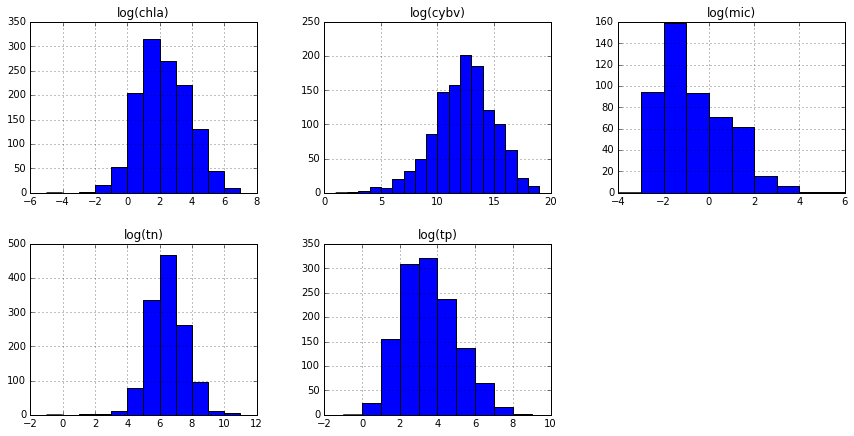

In [76]:
# histograms for anna
# fig,ax = plt.subplots(2,3,figsize=(12,6))
# plt.tight_layout()
# plaxes = [ax[0,0],ax[0,1],ax[0,2],ax[1,0],ax[1,1],ax[1,2]]
# k=0
# for whichmodel in ['chla','cybv','mic','tn','tp']:
#     df = dict_meta[whichmodel][0]
#     respvar = dict_meta[whichmodel][1]
#     dispvar = np.exp(df[respvar])
#     dispvar.name = whichmodel
# #     print(dispvar)
#     pd.DataFrame(dispvar).hist(ax=plaxes[k])
#     k+=1
# plaxes[5].remove()
# plt.show()

bins_edges = [range(-5,9),range(1,21),range(-4,7),range(-1,13),range(-1,10)]
fig,ax = plt.subplots(2,3,figsize=(12,6))
plt.tight_layout()
plaxes = [ax[0,0],ax[0,1],ax[0,2],ax[1,0],ax[1,1],ax[1,2]]
k=0
for whichmodel in ['chla','cybv','mic','tn','tp']:
    df = dict_meta[whichmodel][0]
    respvar = dict_meta[whichmodel][1]
    dispvar = np.exp(df[respvar])
    dispvar = np.log(dispvar)
    dispvar.name = 'log({})'.format(whichmodel)
#     print(dispvar)
    pd.DataFrame(dispvar).hist(ax=plaxes[k],bins=bins_edges[k])
    k+=1
plaxes[5].remove()
plt.show()


[['(0, 8)', '(8, 81)', '(81, 340)', '(340, 940)'], ['(19, 2.6E5)', '(2.6E5, 6.7E6)', '(6.7E6, 5.9E7)', '(5.9E7, 1.7E8)'], ['(0.1, 0.4)', '(0.4, 4.3)', '(4.3, 28)', '(28, 190)'], ['(5, 620)', '(620, 2700)', '(2700, 8500)', '(8500, 54000)'], ['(1, 33)', '(33, 260)', '(260, 1200)', '(1200, 3600)']]
['[0.07, 8.4]', '(8.4, 81.2]', '(81.2, 343.5]', '(343.5, 937]']
['[19.3, 259856.03]', '(259856.03, 6779204.8]', '(6779204.8, 59841333.06]', '(59841333.06, 171850589.9]']
['[0.1, 0.4]', '(0.4, 4.3]', '(4.3, 28.3]', '(28.3, 193]']
['[5, 616]', '(616, 2747.1]', '(2747.1, 8527.5]', '(8527.5, 54000]']
['[1, 34]', '(34, 264.1]', '(264.1, 1212.7]', '(1212.7, 3637]']


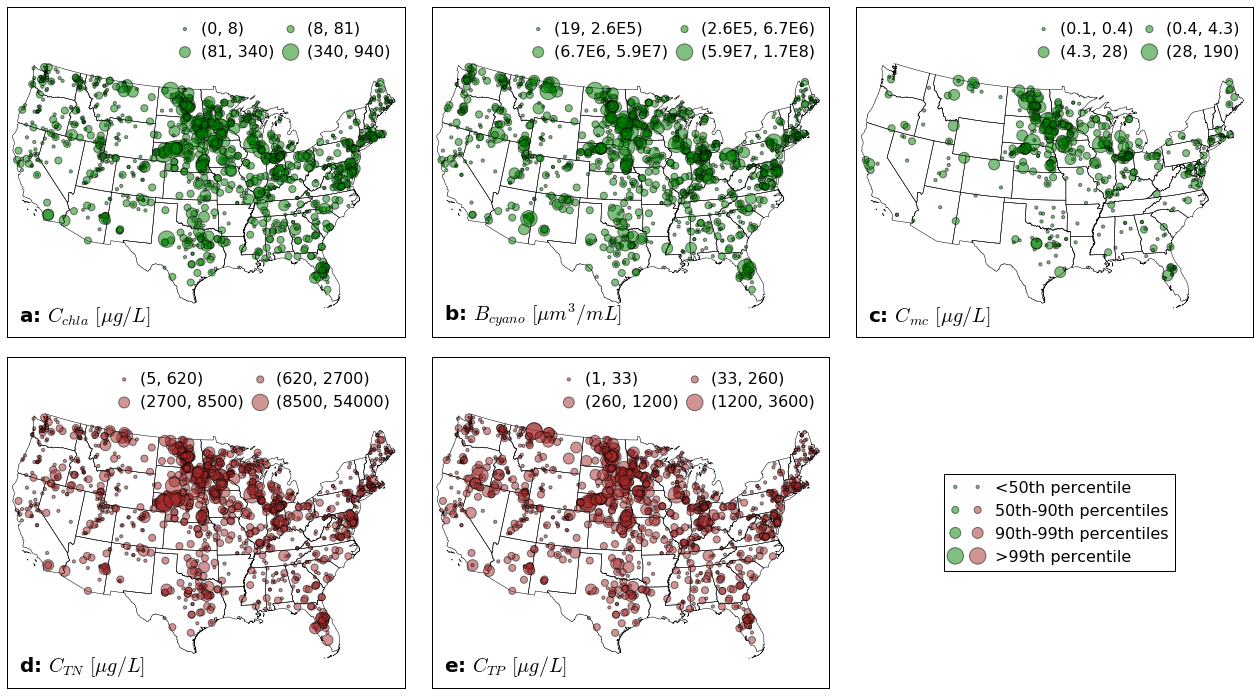

In [9]:
# Fig 1 locations of response variables
# fig = plt.figure(figsize=(10,7))
fig,ax = plt.subplots(2,3,figsize=(18,10),sharex=True,sharey=True)
plt.tight_layout()
plaxes = [ax[0,0],ax[0,1],ax[0,2],ax[1,0],ax[1,1],ax[1,2]]
# plaxes = [ax[0,0],ax[1,0],ax[2,0],ax[0,1],ax[1,1],ax[2,1]]
# exes=[[-1,6],[4,18],[0,1],[-3,4],[3,10],[0,7]]
# tx=[[-1,7,1],[4,20,2],[0.0,1.2,0.2],[-3,5,1],[3,11,1],[0,8,1]]

scatter_sizes = [10,50,120,270]
scatter_sizes_leg = [[10,10],[50,50],[120,120],[270,270]]
binstrs_list =[['(0, 8)', '(8, 81)', '(81, 340)', '(340, 940)'],
               ['(19, 2.6E5)', '(2.6E5, 6.7E6)', '(6.7E6, 5.9E7)', '(5.9E7, 1.7E8)'],
               ['(0.1, 0.4)', '(0.4, 4.3)', '(4.3, 28)', '(28, 190)'],
               ['(5, 620)', '(620, 2700)', '(2700, 8500)', '(8500, 54000)'],
               ['(1, 33)', '(33, 260)', '(260, 1200)', '(1200, 3600)']]

print(binstrs_list)
leg_sizes = ['<50th percentile','50th-90th percentiles','90th-99th percentiles','>99th percentile']
cs=['g','g','g','brown','brown']
cs_leg=['g','brown']
#for bw versions
# cs=['grey','grey','grey','grey','grey']
# cs_leg=['grey','grey']
fsize=20
k=0
for whichmodel in ['chla','cybv','mic','tn','tp']:
#     print(whichmodel)
    df = dict_meta[whichmodel][0]
    respvar = dict_meta[whichmodel][1]
    dispvar = np.exp(df[respvar])
    dispvar_cats = pd.qcut(dispvar,q=[0,.5,.9,.99,1],precision=0)
#     print(dispvar_cats.head())
    binstrs = dispvar_cats.cat.categories.values
    print(list(binstrs))
    size_dict = dict(zip(binstrs,scatter_sizes))    
    n=len(df)

    # Create basemap and load US states shapefile
    map = Basemap(llcrnrlon=-119.5,llcrnrlat=25,urcrnrlon=-63.5,urcrnrlat=48.5,
            projection='lcc',lat_1=33,lat_2=45,lon_0=-95)
    map.readshapefile('../USstatesSHP/st99_d00', name='states', drawbounds=True,ax=plaxes[k])

    # Add lon/lat data
    x,y = map(df['lon_dd'].values, df['lat_dd'].values)
    map.scatter(x, y, s=dispvar_cats.map(lambda x: size_dict[x]),#offsets_b[k]+offsets_m[k]*dispvar,
                c=cs[k],alpha=0.5,
                label=whichmodel,zorder=10,ax=plaxes[k])

    leg_sizes = binstrs_list[k]
    l1 = plaxes[k].scatter([],[], s=scatter_sizes[0],c=cs[k],alpha=0.5)
    l2 = plaxes[k].scatter([],[], s=scatter_sizes[1],c=cs[k],alpha=0.5)
    l3 = plaxes[k].scatter([],[], s=scatter_sizes[2],c=cs[k],alpha=0.5)
    l4 = plaxes[k].scatter([],[], s=scatter_sizes[3],c=cs[k],alpha=0.5)

    leg = plaxes[k].legend([l1,l3,l2,l4], [leg_sizes[x] for x in [0,2,1,3]], ncol=2, frameon=False,# loc=3,
                           fontsize=16,handletextpad=0.01,columnspacing=0.01)#,title=legnames[k])
    
    if k==4:
        plaxes[k].add_artist(leg)
        l1 = plaxes[k].scatter([],[], s=scatter_sizes_leg[0],c=cs_leg,alpha=0.5)
        l2 = plaxes[k].scatter([],[], s=scatter_sizes_leg[1],c=cs_leg,alpha=0.5)
        l3 = plaxes[k].scatter([],[], s=scatter_sizes_leg[2],c=cs_leg,alpha=0.5)
        l4 = plaxes[k].scatter([],[], s=scatter_sizes_leg[3],c=cs_leg,alpha=0.5)
        leg_sizes = ['<50th percentile','50th-90th percentiles','90th-99th percentiles','>99th percentile']
        leg = plaxes[k].legend([l1,l2,l3,l4], leg_sizes, ncol=1, frameon=True,scatterpoints=2,
                               scatteryoffsets=[0.5],
                               fontsize=16,#,handletextpad=0.01,columnspacing=0.01)#,title=legnames[k])
                               loc='center', bbox_to_anchor=(1.58, 0.5),)
    
    small_x = plaxes[k].get_xlim()[1]*0.03
    small_y = plaxes[k].get_ylim()[1]*-0.17
    big_y = plaxes[k].get_ylim()[1]*1.09
#     plaxes[k].text(small_x,big_y,letters[k],color='k',fontsize=fsize,fontweight='bold')
#     plaxes[k].text(small_x,small_y,legnames_short[k],color='k',fontsize=fsize)
    plaxes[k].text(small_x,small_y,'{}: {}'.format(letters[k],legnames_short[k]),
               ha='left',color='k',fontsize=fsize,fontweight='bold')
    k+=1

plaxes[5].remove()
plt.savefig('figures_to_look_at/FinalFigs/HoMichalak_Fig1.png',dpi=300)
plt.savefig('figures_to_look_at/FinalFigs/HoMichalak_Fig1.pdf',dpi=300)
# plt.savefig('figures_to_look_at/map_resp_vars_bins2.png',dpi=300)
# plt.savefig('figures_to_look_at/map_resp_vars_bins2.pdf',dpi=300)
# plt.savefig('figures_to_look_at/map_resp_vars_bins2_bw.png',dpi=300)
# plt.savefig('figures_to_look_at/map_resp_vars_bins2_bw.pdf',dpi=300)
plt.show()


chla
1
['TN_tn_log', 'TP_tp_log', 'airtemp_jja', 'prec_tot_ann_mm_log']
cybv
1
['TN_tn_log', 'TP_tp_log', 'airtemp_mam', 'depth_m_log']
mic
3
['TN_tn_log', 'airtemp_mam']


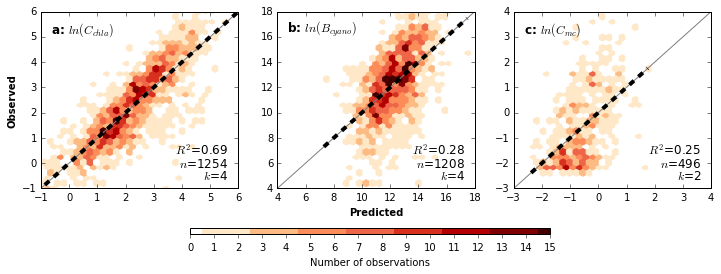

In [32]:
#Fig 2 obs vs pred

fig,ax = plt.subplots(1,3,figsize=(10,3)) #7,9
plt.tight_layout()
# plaxes = [ax[0,0],ax[0,1],ax[1,0],ax[1,1],ax[2,0],ax[2,1]]
# plaxes = [ax[0,0],ax[0,1],ax[0,2],ax[1,0],ax[1,1],ax[1,2]]
# plaxes = [ax[0,0],ax[0,1],ax[1,0],ax[1,1]]
plaxes = [ax[0],ax[1],ax[2]]
# exes=[[-1,6],[4,18],[0,1],[-3,4],[3,10],[0,7]]
exes=[[-1,6],[4,18],[-3,4],[3,10],[0,7]]
# tx=[[-1,7,1],[4,20,2],[0.0,1.2,0.2],[-3,5,1],[3,11,1],[0,8,1]]
tx=[[-1,7,1],[4,20,2],[-3,5,1],[3,11,1],[0,8,1]]
    
k=0
for whichmodel in ['chla','cybv','mic']:#,'tn','tp']:
    print(whichmodel)
    df = dict_meta[whichmodel][0]
    n=len(df)
    
    #get best_ols_vars as a list
#     display(df.head())
    best_models = pd.DataFrame.from_csv(
        'best_models/best_models_{}_{}_{}.csv'.format(whichmodel,whichyear,suff))
    best_models = best_models.sort_values(by='n',ascending=False)
    best_models.loc[:,'BIC_diff'] = np.append(np.diff(best_models['BIC']),np.nan)
    best_row = 0
    BIC_imp_of_best = best_models.iloc[best_row].BIC_diff
    while (BIC_imp_of_best<10):
        best_row+=1
        BIC_imp_of_best = best_models.iloc[best_row].BIC_diff
    print(best_row)
#     display(best_models)
    best_ols_vars = best_models.iloc[best_row].model
    best_ols_vars = ast.literal_eval(best_ols_vars) #need literal eval because otherwise is str
    best_ols_vars = list(best_ols_vars)
    print(best_ols_vars)
    
    #get regressionresults object
    def get_mod(i_vars,dafr):
        df_i = dafr[[dict_meta[whichmodel][1]]+i_vars].copy()
        y = df_i[dict_meta[whichmodel][1]]
        X = df_i[i_vars]
        est = get_ols(X,y)
        return [est,df_i]
    [best_ols,best_ols_df] = get_mod(best_ols_vars,df)
#     print(best_ols.summary())
#     print(best_ols.bic)
    rsq = best_ols.rsquared

    #plot predicted vs obs using hexbin
    fitted = best_ols.fittedvalues
    obs = df[dict_meta[whichmodel][1]]
    hb=plaxes[k].hexbin(fitted, obs, gridsize=30, cmap=cm,vmin=0,vmax=15,extent=exes[k]+exes[k])
    plaxes[k].plot(exes[k],exes[k],'-',color='grey',linewidth=1)
    
    #plot bestfit line
    x_range = (fitted.min(),fitted.max())
    pred_obs_ols = get_ols(fitted,obs)
#     print(pred_obs_ols.summary())
    plaxes[k].plot(x_range,get_y_ends(x_range,pred_obs_ols.params),'k--',lw=4)

    #set axes, ticks, etc.
    plaxes[k].axis(exes[k]+exes[k])
    plaxes[k].set_xticks(np.arange(tx[k][0],tx[k][1],tx[k][2]), minor=False)
    plaxes[k].set_yticks(np.arange(tx[k][0],tx[k][1],tx[k][2]), minor=False)
    
    #add text
    small_x = exes[k][0]+(exes[k][1]-exes[k][0])*0.05
    big_x = exes[k][0]+(exes[k][1]-exes[k][0])*0.95
    small_y = exes[k][0]+(exes[k][1]-exes[k][0])*0.05
    small_y_abv = exes[k][0]+(exes[k][1]-exes[k][0])*0.12
    small_y_abv2 = exes[k][0]+(exes[k][1]-exes[k][0])*0.19
    big_y = exes[k][0]+(exes[k][1]-exes[k][0])*0.88
    big_y_blw = exes[k][0]+(exes[k][1]-exes[k][0])*0.82
#     plaxes[k].text(small_x,big_y,letters[k],color='k',fontsize=12,fontweight='bold')
#     plaxes[k].text(small_x,big_y_blw,modelnames[k],color='k',fontsize=12)
    plaxes[k].text(small_x,big_y,'{}: {}'.format(letters[k],modelnames[k]),color='k',fontsize=12,
                   fontweight='bold')
    plaxes[k].text(big_x,small_y_abv2,'$R^2$={:0.2f}'.format(rsq),color='k',ha='right',fontsize=12)
    plaxes[k].text(big_x,small_y_abv,'$n$={}'.format(n),color='k',ha='right',fontsize=12)
    plaxes[k].text(big_x,small_y,'$k$={}'.format(len(best_ols_vars)),color='k',ha='right',fontsize=12)
    k+=1

#legends plus caxis
plaxes[0].set_ylabel('Observed',fontweight='bold')
plaxes[1].set_xlabel('Predicted',fontweight='bold')
# plaxes[5].text(-0.72,-1.1,'Predicted',ha='center',fontweight='bold')
# plaxes[2].text(-3.75,-4.5,'Predicted',ha='center',fontweight='bold')
# plaxes[0].text(-2,-1,'Observed',ha='right',fontweight='bold',rotation=90)
# cbaxes = fig.add_axes([0.06, -0.10, 0.905, 0.025]) #2x3
# cbaxes = fig.add_axes([0.125, -0.1, 0.75, 0.025]) #2x2
cbaxes = fig.add_axes([0.25, -0.1, 0.5, 0.025]) #1x3
# cbaxes = fig.add_axes([1, 0.125, 0.025, 0.75]) 
# cb = fig.colorbar(hb,cax=cbaxes,ticks=np.arange(0,16,5),orientation='vertical')
# cb.set_label('Number\nof\nobservations',rotation=0,ha='left')
cb = fig.colorbar(hb,cax=cbaxes,ticks=[0]+range(1,16),#[0,1,3,5,7,9,11,13,15],
                  orientation='horizontal')
cb.ax.tick_params(direction='out') 
cb.set_label('Number of observations',rotation=0,ha='center')

# plt.savefig('figures_to_look_at/best_models_fit_6_bw.png',bbox_inches='tight',dpi=300)
# plt.savefig('figures_to_look_at/best_models_fit_6_bw.pdf',bbox_inches='tight',dpi=300)
plt.savefig('figures_to_look_at/FinalFigs/HoMichalak_Fig2.png',bbox_inches='tight',dpi=300)
plt.savefig('figures_to_look_at/FinalFigs/HoMichalak_Fig2.pdf',bbox_inches='tight',dpi=300)
plt.show()

['TN_tn_log', 'TP_tp_log', 'airtemp_jja', 'prec_tot_ann_mm_log']
1254
1254
1254
2508
1254
3762
1254
5016
Index([u'(0, 2]', u'(2, 4]', u'(4, 6]', u'(6, 8]'], dtype='object')
['(0, 2]', '(2, 4]', '(4, 6]', '(6, 8]']
TN_tn_log
0.598673864811


'Number of obs with negative XBs:'

0

['(0, 2]', '(2, 4]', '(4, 6]', '(6, 8]']
$0.60 \  ln(C_{TN})$
TP_tp_log
0.432727860266


'Number of obs with negative XBs:'

0

['(0, 2]', '(2, 4]', '(4, 6]', '(6, 8]']
$0.43 \ ln(C_{TP})$
airtemp_jja
0.0657371170805


'Number of obs with negative XBs:'

0

['(0, 2]', '(2, 4]', '(4, 6]', '(6, 8]']
$0.066 \ T_{air,JJA}$
prec_tot_ann_mm_log
0.533925197141


'Number of obs with negative XBs:'

0

['(0, 2]', '(2, 4]', '(4, 6]', '(6, 8]']
$0.53 \ ln(P_{annual})$


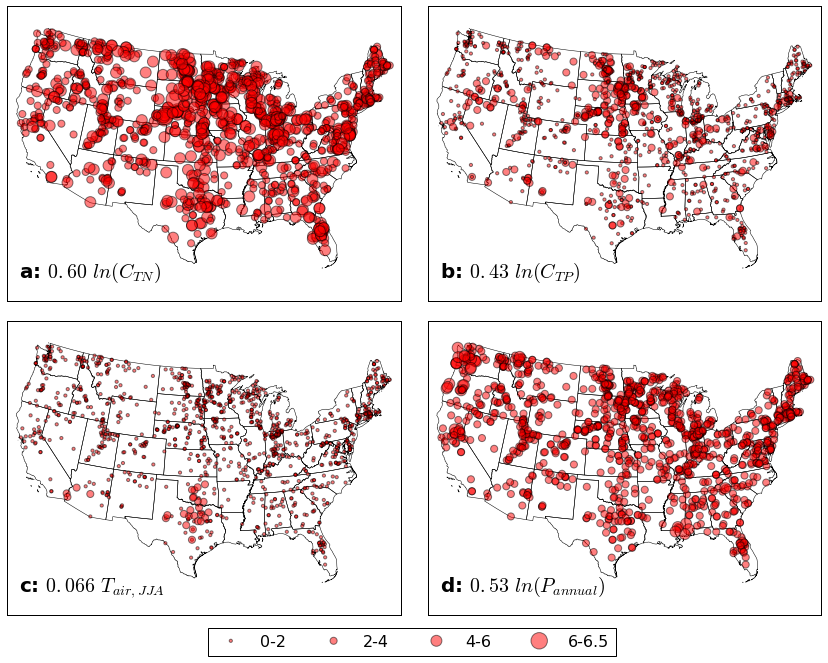

['TN_tn_log', 'TP_tp_log', 'airtemp_mam', 'depth_m_log']
1208
1208
1208
2416
1208
3624
1208
4832
Index([u'(0, 2]', u'(2, 4]', u'(4, 6]', u'(6, 8]'], dtype='object')
['(0, 2]', '(2, 4]', '(4, 6]', '(6, 8]']
TN_tn_log
0.720342611915


'Number of obs with negative XBs:'

0

['(0, 2]', '(2, 4]', '(4, 6]', '(6, 8]']
$0.72 \ ln(C_{TN})$
TP_tp_log
0.539443808715


'Number of obs with negative XBs:'

0

['(0, 2]', '(2, 4]', '(4, 6]', '(6, 8]']
$0.54 \ ln(C_{TP})$
airtemp_mam
0.05895175829


'Number of obs with negative XBs:'

20

['(0, 2]', '(2, 4]', '(4, 6]', '(6, 8]']
$0.059 \ T_{air,MAM}$
depth_m_log
0.397764546132


'Number of obs with negative XBs:'

6

['(0, 2]', '(2, 4]', '(4, 6]', '(6, 8]']
$0.40 \ ln(D)$


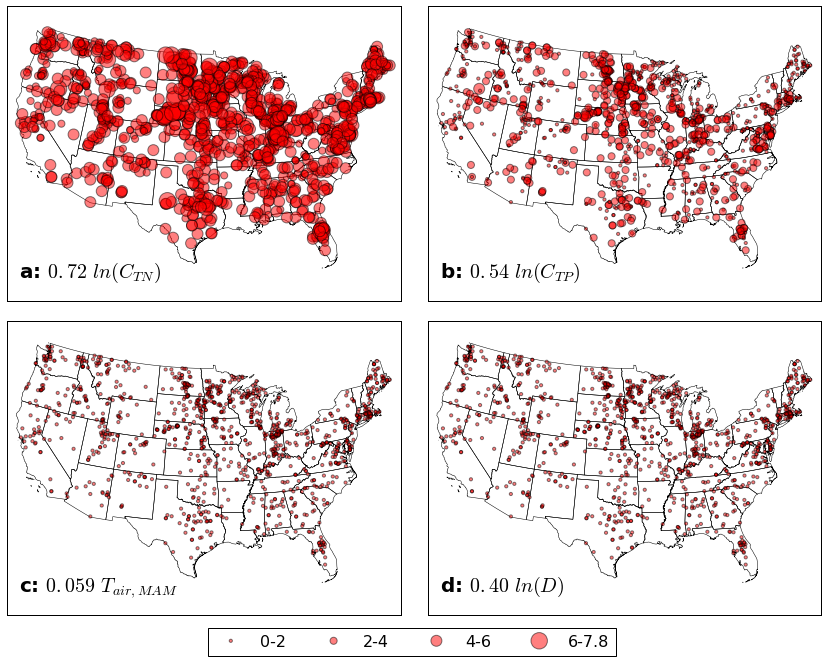

['TN_tn_log', 'airtemp_mam']
496
496
496
992
Index([u'(0, 2]', u'(2, 4]', u'(4, 6]', u'(6, 8]'], dtype='object')
['(0, 2]', '(2, 4]', '(4, 6]', '(6, 8]']
TN_tn_log
0.666780685623


'Number of obs with negative XBs:'

0

['(0, 2]', '(2, 4]', '(4, 6]', '(6, 8]']
$0.67 \ ln(C_{TN})$
airtemp_mam
-0.073205967574


'Number of obs with negative XBs:'

496

['(0, 2]', '(2, 4]', '(4, 6]', '(6, 8]']
$-0.073 \ T_{air,MAM}$


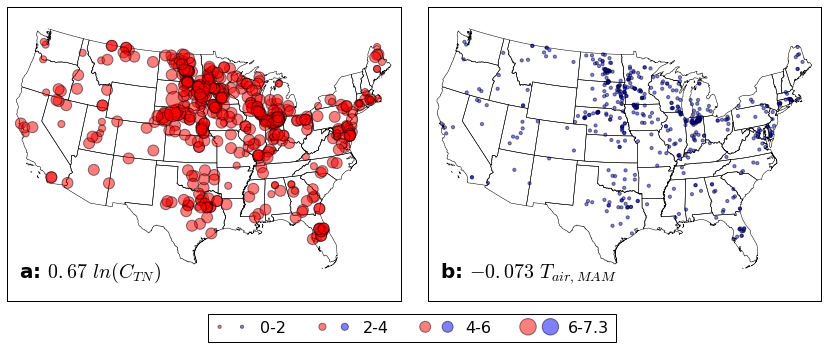

['cur_NAPI_FERT', 'cur_NANI_FERT_log', 'prec_tot_ann_mm', 'E_pr_gt95_jja', 'depth_m_log']
1260
1260
1260
2520
1260
3780
1260
5040
1260
6300
Index([u'(0, 2]', u'(2, 4]', u'(4, 6]', u'(6, 8]'], dtype='object')
['(0, 2]', '(2, 4]', '(4, 6]', '(6, 8]']
cur_NAPI_FERT
0.000466048457257


'Number of obs with negative XBs:'

0

['(0, 2]', '(2, 4]', '(4, 6]', '(6, 8]']
$0.00046 \ FPI$
cur_NANI_FERT_log
0.0948468813222


'Number of obs with negative XBs:'

16

['(0, 2]', '(2, 4]', '(4, 6]', '(6, 8]']
$0.095 \ ln(FNI)$
prec_tot_ann_mm
-0.000927363870731


'Number of obs with negative XBs:'

1260

['(0, 2]', '(2, 4]', '(4, 6]', '(6, 8]']
$-0.00093 \ P_{annual}$
E_pr_gt95_jja
0.00215657766883


'Number of obs with negative XBs:'

0

['(0, 2]', '(2, 4]', '(4, 6]', '(6, 8]']
$0.0022 \ P_{JJA,p>0.95}$
depth_m_log
-0.54526980545


'Number of obs with negative XBs:'

1229

['(0, 2]', '(2, 4]', '(4, 6]', '(6, 8]']
$-0.55 \ ln(D)$


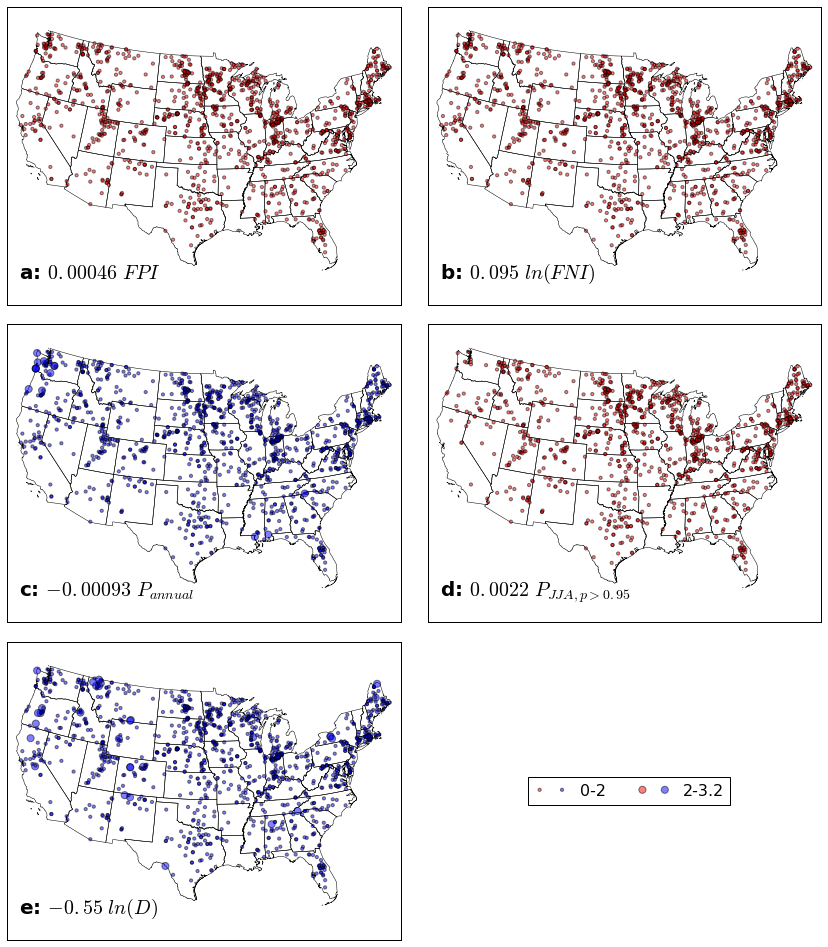

['cur_NAPI_FERT', 'airtemp_jja', 'prec_tot_ann_mm_log', 'depth_m_log', 'lon_dd']
1260
1260
1260
2520
1260
3780
1260
5040
1260
6300
Index([u'(0, 2]', u'(2, 4]', u'(4, 6]', u'(6, 8]'], dtype='object')
['(0, 2]', '(2, 4]', '(4, 6]', '(6, 8]']
cur_NAPI_FERT
0.00102046070884


'Number of obs with negative XBs:'

0

['(0, 2]', '(2, 4]', '(4, 6]', '(6, 8]']
$0.0010 \ FPI$
airtemp_jja
0.076072944272


'Number of obs with negative XBs:'

0

['(0, 2]', '(2, 4]', '(4, 6]', '(6, 8]']
$0.076 \ T_{air,JJA}$
prec_tot_ann_mm_log
-0.579578798029


'Number of obs with negative XBs:'

1260

['(0, 2]', '(2, 4]', '(4, 6]', '(6, 8]']
$-0.58 \ ln(P_{annual})$
depth_m_log
-0.791337204223


'Number of obs with negative XBs:'

1229

['(0, 2]', '(2, 4]', '(4, 6]', '(6, 8]']
$-0.79 \ ln(D)$
lon_dd
-0.0165686902335


'Number of obs with negative XBs:'

0

['(0, 2]', '(2, 4]', '(4, 6]', '(6, 8]']
$-0.016 \ Lon$


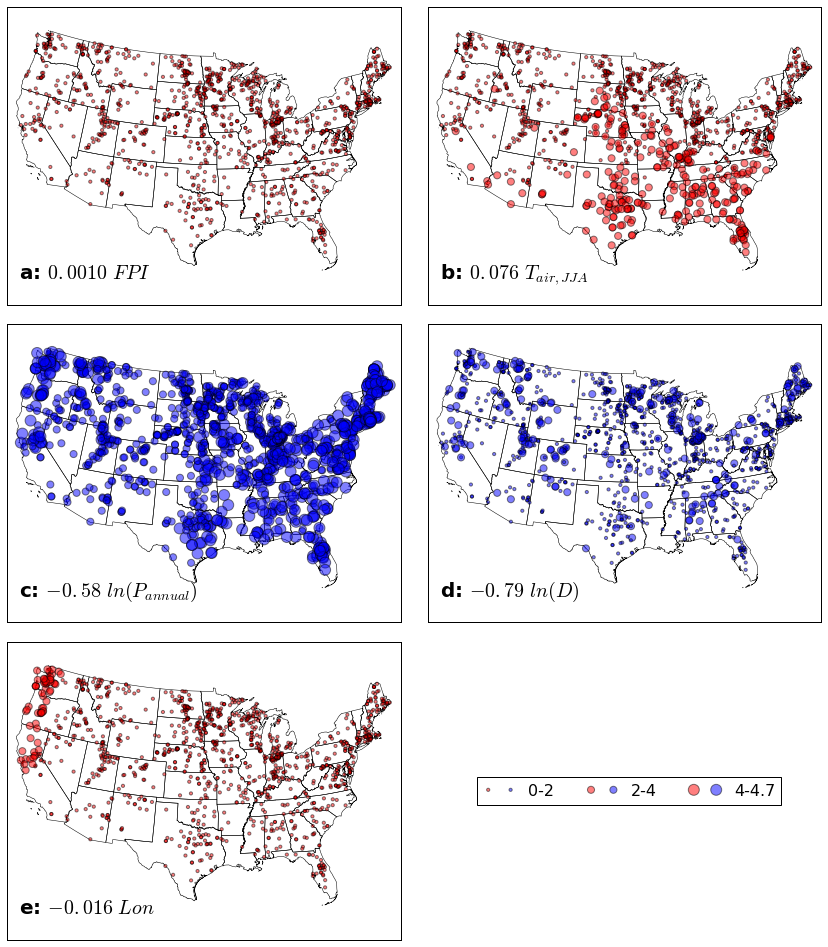

In [3]:
# new fig 3 fig 4 fig 5 locations of XB
scatter_sizes = [10,50,120,270]
scatter_sizes_leg = [[10,10],[50,50],[120,120],[270,270]]

leg_sizes = ['<50th percentile','50th-90th percentiles','90th-99th percentiles','>99th percentile']
#for bw versions
# cs=['grey','grey','grey','grey','grey']
# cs_leg=['grey','grey']
fsize=20
k=0

cs_dict={'chla':['r','r','r','r'],
         'cybv':['r','r','r','r'],
         'mic':['r','b'],
         'tn':['r','r','b','r','b'],
         'tp':['r','r','b','b','r'],}
cs_leg_dict={'chla':['r','b'],'cybv':['r','r'],'mic':['r','b'],'tn':['r','b'],'tp':['r','b']}
scatterpoints_dict = {'chla':1,'cybv':1,'mic':2,'tn':2,'tp':2}
legnames_short_dict={
    'chla':[r'$0.60 \  ln(C_{TN})$',
            r'$0.43 \ ln(C_{TP})$',
            r'$0.066 \ T_{air,JJA}$',
            r'$0.53 \ ln(P_{annual})$'],
    'cybv':[r'$0.72 \ ln(C_{TN})$',
            r'$0.54 \ ln(C_{TP})$',
            r'$0.059 \ T_{air,MAM}$',
            r'$0.40 \ ln(D)$'],
    'mic' :[r'$0.67 \ ln(C_{TN})$',
            r'$-0.073 \ T_{air,MAM}$'],
    'tn':  [r'$0.00046 \ FPI$',
            r'$0.095 \ ln(FNI)$',
            r'$-0.00093 \ P_{annual}$',
            r'$0.0022 \ P_{JJA,p>0.95}$',
            r'$-0.55 \ ln(D)$'],
    'tp':  [r'$0.0010 \ FPI$',
            r'$0.076 \ T_{air,JJA}$',
            r'$-0.58 \ ln(P_{annual})$',
            r'$-0.79 \ ln(D)$',
            r'$-0.016 \ Lon$'],
}

for fig_minus_3,whichmodel in enumerate(['chla','cybv','mic','tn','tp']):
    if whichmodel in ['chla','cybv','mic']:
        fig,ax = plt.subplots(2,2,figsize=(12,9),sharex=True,sharey=True)
        plt.tight_layout()
        plaxes = [ax[0,0],ax[0,1],ax[1,0],ax[1,1]]
    else:   
        fig,ax = plt.subplots(3,2,figsize=(12,13.5),sharex=True,sharey=True)
        plt.tight_layout()
        plaxes = [ax[0,0],ax[0,1],ax[1,0],ax[1,1],ax[2,0],ax[2,1]]
    
    cs=cs_dict[whichmodel]
    cs_leg=cs_leg_dict[whichmodel]
    legnames_short=legnames_short_dict[whichmodel]
#     print(whichmodel)
    df = dict_meta[whichmodel][0]
    n=len(df)
    
    #get best_ols_vars as a list
#     display(df.head())
    best_models = pd.DataFrame.from_csv(
        'best_models/best_models_{}_{}_{}.csv'.format(whichmodel,whichyear,suff))
    best_models = best_models.sort_values(by='n',ascending=False)
    best_models.loc[:,'BIC_diff'] = np.append(np.diff(best_models['BIC']),np.nan)
    best_row = 0
    BIC_imp_of_best = best_models.iloc[best_row].BIC_diff
    while (BIC_imp_of_best<10):
        best_row+=1
        BIC_imp_of_best = best_models.iloc[best_row].BIC_diff
#     display(best_models)
    best_ols_vars = best_models.iloc[best_row].model
    best_ols_vars = ast.literal_eval(best_ols_vars) #need literal eval because otherwise is str
    best_ols_vars = list(best_ols_vars)
    
    #sort best_ols_vars by allvar_names_ordered
    best_ols_vars = [varname for varname in allvar_names_ordered if varname in best_ols_vars]
    print(best_ols_vars)
    
    #get regressionresults object
    def get_mod(i_vars,dafr):
        df_i = dafr[[dict_meta[whichmodel][1]]+i_vars].copy()
        y = df_i[dict_meta[whichmodel][1]]
        X = df_i[i_vars]
        est = get_ols(X,y)
        return [est,df_i]
    [best_ols,best_ols_df] = get_mod(best_ols_vars,df)
    
    #determine 4 bins based off of ALL XB datas, not just for each map.
    dispvar_all = []
    for k,best_ols_var in enumerate(best_ols_vars):
        respvar = best_ols_var
        beta = best_ols.params[best_ols_var]
        dispvar = list(np.abs(beta*best_ols_df[respvar].values))
        print(len(dispvar))
        dispvar_all = dispvar_all+dispvar
        print(len(dispvar_all))
    dispvar_all_max = max(dispvar_all)
#     dispvar_cats,binedges = pd.qcut(dispvar_all,q=[0,.5,.9,.99,1],retbins=True,precision=0)
    binedges = [0,2,4,6,8]
    dispvar_cats = pd.cut(dispvar_all,bins=binedges,precision=0)
    binstrs_all = dispvar_cats.categories.values
    print(dispvar_cats.categories)
    print(list(binstrs_all))
    size_dict_all = dict(zip(binstrs_all,scatter_sizes))
            
    for k,best_ols_var in enumerate(best_ols_vars):
        print(best_ols_var)
        respvar = best_ols_var
        beta = best_ols.params[best_ols_var]
        print(beta)
        dispvar = beta*best_ols_df[respvar]
    #     print(dispvar)
        display('Number of obs with negative XBs:', len(dispvar.loc[dispvar<0]))
#         display(dispvar.loc[dispvar<0])
        dispvar = np.abs(dispvar)

        dispvar_cats = pd.cut(dispvar,bins=binedges,precision=0)
    #     print(dispvar_cats.head())
        binstrs = dispvar_cats.cat.categories
        print(list(binstrs))
        size_dict = dict(zip(binstrs,scatter_sizes))

        # Create basemap and load US states shapefile
#         if whichmodel in ['chla','cybv','mic']:
#             map = Basemap(llcrnrlon=-120,llcrnrlat=25,urcrnrlon=-65.5,urcrnrlat=44.5,
#                     projection='lcc',lat_1=33,lat_2=45,lon_0=-95)
#         else:
#             map = Basemap(llcrnrlon=-119.5,llcrnrlat=25,urcrnrlon=-63.5,urcrnrlat=48.5,
#                     projection='lcc',lat_1=33,lat_2=45,lon_0=-95)
        map = Basemap(llcrnrlon=-120,llcrnrlat=25,urcrnrlon=-65.5,urcrnrlat=44.5,
                projection='lcc',lat_1=33,lat_2=45,lon_0=-95)
        map.readshapefile('../USstatesSHP/st99_d00', name='states', drawbounds=True,ax=plaxes[k])

        # Add lon/lat data
#         if whichmodel=='cybv' and k==2:
#             x,y = map(df.loc[df[respvar]>0,'lon_dd'].values, df.loc[df[respvar]>0,'lat_dd'].values)
#             map.scatter(x, y, s=dispvar_cats.loc[df[respvar]>0].map(lambda x: size_dict[x]),
#                         c=cs[k],alpha=0.5,
#                         label=whichmodel,zorder=10,ax=plaxes[k])
#             x_neg,y_neg = map(df.loc[df[respvar]<0,'lon_dd'].values, df.loc[df[respvar]<0,'lat_dd'].values)
#             map.scatter(x_neg, y_neg, s=dispvar_cats.loc[df[respvar]<0].map(lambda x: size_dict[x]),
#                         c='b',alpha=0.5,
#                         label=whichmodel,zorder=10,ax=plaxes[k])
#         else:
        x,y = map(df['lon_dd'].values, df['lat_dd'].values)
        map.scatter(x, y, s=dispvar_cats.map(lambda x: size_dict[x]),
                    c=cs[k],alpha=0.5,
                    label=whichmodel,zorder=10,ax=plaxes[k])

#         leg_sizes = binstrs
#         l1 = plaxes[k].scatter([],[], s=scatter_sizes[0],c=cs[k],alpha=0.5)
#         l2 = plaxes[k].scatter([],[], s=scatter_sizes[1],c=cs[k],alpha=0.5)
#         l3 = plaxes[k].scatter([],[], s=scatter_sizes[2],c=cs[k],alpha=0.5)
#         l4 = plaxes[k].scatter([],[], s=scatter_sizes[3],c=cs[k],alpha=0.5)

#         leg = plaxes[k].legend([l1,l3,l2,l4], [leg_sizes[x] for x in [0,2,1,3]], ncol=2, frameon=False,# loc=3,
#                                fontsize=16,handletextpad=0.01,columnspacing=0.01)#,title=legnames[k])
        if k==len(best_ols_vars)-1:
#             plaxes[k].add_artist(leg)
            l1 = plaxes[k].scatter([],[], s=scatter_sizes_leg[0],c=cs_leg,alpha=0.5)
            l2 = plaxes[k].scatter([],[], s=scatter_sizes_leg[1],c=cs_leg,alpha=0.5)
            l3 = plaxes[k].scatter([],[], s=scatter_sizes_leg[2],c=cs_leg,alpha=0.5)
            l4 = plaxes[k].scatter([],[], s=scatter_sizes_leg[3],c=cs_leg,alpha=0.5)
            leg_sizes = ['<50th percentile','50th-90th percentiles','90th-99th percentiles','>99th percentile']
            leg_sizes = binstrs_all
            if whichmodel in ['chla','cybv','mic']:
                leg_sizes = ['0-2','2-4','4-6','6-{}'.format(round(dispvar_all_max,1))]
                leg_list = [l1,l2,l3,l4]
                leg = plaxes[k].legend(leg_list, leg_sizes, ncol=4, frameon=True,
                                       scatterpoints=scatterpoints_dict[whichmodel],
                                       scatteryoffsets=[0.5],
                                       fontsize=16,#,handletextpad=0.01,columnspacing=0.01)#,title=legnames[k])
                                       loc='center', bbox_to_anchor=(-0.04, -0.09))   
            elif whichmodel == 'tn':
                leg_sizes = ['0-2','2-{}'.format(round(dispvar_all_max,1))]
                leg_list = [l1,l2]
            elif whichmodel == 'tp':
                leg_sizes = ['0-2','2-4','4-{}'.format(round(dispvar_all_max,1))]
                leg_list = [l1,l2,l3]
            if 't' in whichmodel:
                leg = plaxes[k].legend(leg_list, leg_sizes, ncol=4, frameon=True,
                       scatterpoints=scatterpoints_dict[whichmodel],
                       scatteryoffsets=[0.5],
                       fontsize=16,#,handletextpad=0.01,columnspacing=0.01)#,title=legnames[k])
                       loc='center', bbox_to_anchor=(1.58, 0.5))   
        
        
#         small_x = plaxes[k].get_xlim()[1]*0.06
#         small_y = plaxes[k].get_ylim()[1]*-0.08
        small_x = plaxes[k].get_xlim()[1]*0.03
        small_y = plaxes[k].get_ylim()[1]*-0.19
                
        big_y = plaxes[k].get_ylim()[1]*1.09
#         plaxes[k].text(small_x,big_y,letters[k],color='k',fontsize=fsize,fontweight='bold')
#         plaxes[k].text(small_x,small_y,legnames_short[k],color='k',fontsize=fsize)
        print(legnames_short[k])
        plaxes[k].text(small_x,small_y,'{}: {}'.format(letters[k],legnames_short[k]),
           ha='left',color='k',fontsize=fsize,fontweight='bold')
    
    for j in range(k+1,len(plaxes)):
        plaxes[j].remove()
#     if whichmodel in ['chla','cybv','mic']:
#         plt.savefig('figures_to_look_at/FinalFigs/HoMichalak_Fig{}.png'.format(3+fig_minus_3),bbox_inches='tight',dpi=300)
#         plt.savefig('figures_to_look_at/FinalFigs/HoMichalak_Fig{}.pdf'.format(3+fig_minus_3),bbox_inches='tight',dpi=300)
#     else:
#         plt.savefig('figures_to_look_at/FinalFigs/HoMichalak_FigS{}.png'.format(3+fig_minus_3),bbox_inches='tight',dpi=300)
#         plt.savefig('figures_to_look_at/FinalFigs/HoMichalak_FigS{}.pdf'.format(3+fig_minus_3),bbox_inches='tight',dpi=300)
    # plt.savefig('figures_to_look_at/map_resp_vars_bins2_bw.png',dpi=300)
    # plt.savefig('figures_to_look_at/map_resp_vars_bins2_bw.pdf',dpi=300)
    plt.show()


['In situ nutrients' 'Nutrient input' 'Nutrient loading' 'Air temperature'
 'Water temperature' 'Total precipitation' 'Extreme precipitation'
 'Geomorphology' 'Drought severity' 'Stratification']


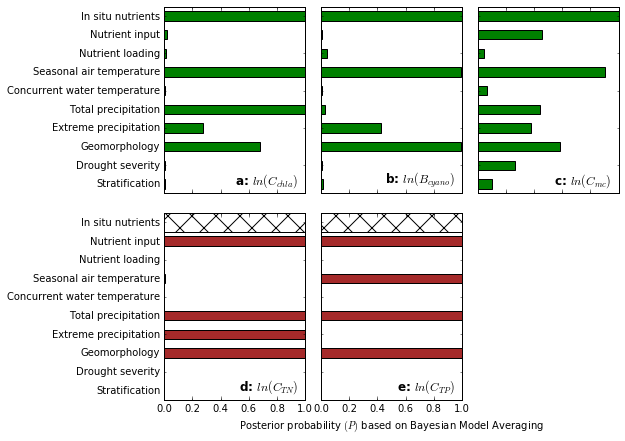

                              probs_chla  probs_cybv  probs_mic      probs_tn  \
cat                                                                             
In situ nutrients               1.000000    1.000000   1.000000  0.000000e+00   
Nutrient input                  0.021293    0.008844   0.452797  9.999978e-01   
Nutrient loading                0.011596    0.041347   0.046777  7.925775e-05   
Seasonal air temperature        0.997979    0.993762   0.903268  7.080890e-03   
Concurrent water temperature    0.001912    0.005394   0.067507  6.115322e-07   
Total precipitation             0.999994    0.027098   0.442531  9.999998e-01   
Extreme precipitation           0.272316    0.423407   0.379652  9.999930e-01   
Geomorphology                   0.681176    0.993752   0.581053  1.000000e+00   
Drought severity                0.001731    0.002867   0.265518  3.340563e-06   
Stratification                  0.002709    0.011336   0.096929  1.154174e-06   

                           

In [29]:
#Fig 6 and 6b BMA scores VERSION WITH categories

# dict_cats = [
#     ('In situ nutrients',['#a65628','T']),
#     ('Temperature',['#e41a1c','temp_']),
#     ('Precipitation',['#377eb8','prec_']),
#     ('Geomorphology',['#b3b3b3','XXX']),
#     ('Nutrient loading',['#66c2a5','flux_']),
#     ('Nutrient input',['#006d2c','cur_']), #4daf4a (old color)
#     ('Drought severity',['#ffff33','pdsi_']),
#     ('Stratification',['#f781bf','strat_']),
# ]
dict_cats = [ #for breaking down temp and precip into two
    ('In situ nutrients',['#a65628','T']),
    ('Nutrient input',['#33a02c','cur_']), #4daf4a (old color)
    ('Nutrient loading',['#b2df8a','flux_']),
    ('Air temperature',['#e31a1c','airtemp_']),
    ('Water temperature',['#fb9a99','temp_']),
    ('Total precipitation',['#1f78b4','prec_']),
    ('Extreme precipitation',['#a6cee3','E_']),
    ('Geomorphology',['#d9d9d9','XXX']), 
    ('Drought severity',['#fdbf6f','pdsi_']),
    ('Stratification',['#6a3d9a','strat_']),
]

dict_cats = collections.OrderedDict(dict_cats)
df_cats = pd.DataFrame.from_dict(dict_cats,orient='index')
df_cats.columns = ['color','prefix']
# display(df_cats)
allcat_names = df_cats.index.values
print(allcat_names)

cat_renames = {'Air temperature':'Seasonal air temperature',
               'Water temperature':'Concurrent water temperature'}

# functions used in each subplot
def return_bmacat(whichmodel,prob_thresh=None,suff_suff=''):
    new_suff = suff+suff_suff
    df_prob = pd.DataFrame.from_csv(
        'bma/bmacatdetailed_{}_{}_{}.csv'.format(whichmodel,whichyear,new_suff))
    df_prob.loc[df_prob['cat']=='Other(s)','cat'] = 'Geomorphology'
    df_prob.loc[df_prob['cat']=='Precip total','cat'] = 'Total precipitation'
    df_prob.loc[df_prob['cat']=='Precip extreme','cat'] = 'Extreme precipitation'
#     display(df_prob)
    df_prob.loc[:,'color'] = df_prob['cat'].map(lambda x: df_cats.loc[x,'color'])
    df_prob.set_index('cat',inplace=True)
    df_prob = df_prob.loc[allcat_names] #get fixed order rather than by probability
    df_prob.rename(index=cat_renames,inplace=True) #rename categories
    if prob_thresh is None:
        df_prob = df_prob #return bma for all cats
    else:
        df_prob = df_prob.loc[df_prob['prob']>prob_thresh]
    return df_prob

# FINALLY, plotting for all variables!
fig,ax = plt.subplots(2,3,figsize=(7,6),sharex=True,sharey=True)
plt.tight_layout(w_pad=0) # adjust w_pad so that variable names don't overlap
plaxes = [ax[0,0],ax[0,1],ax[0,2],ax[1,0],ax[1,1],ax[1,2]]
# plaxes = [ax[0,0],ax[1,0],ax[2,0],ax[0,1],ax[1,1],ax[2,1]]
k=0
prob_t = 0.15
df_probses = []
for whichmodel in ['chla','cybv','mic','tn','tp']:
    # plot individual top categories by bma
    df_probs = return_bmacat(whichmodel)#prob_thresh=prob_t)
#     display(df_probs)
    df_probses.append(df_probs['prob'])
    twocolor_col = 'g'
#     twocolor_col = 'grey' #for bw
    if whichmodel in ['tn','tp']:
        plaxes[k].barh(-0.5,width=1,height=1,edgecolor='black',color='white',hatch='x')
        twocolor_col = 'brown'
#         twocolor_col = 'grey' #for bw
    df_probs['prob'].plot.barh(ax=plaxes[k],color=twocolor_col)#color=list(df_probs['color'])) #color='#4daf4a')
    plaxes[k].invert_yaxis()
    plaxes[k].set_ylabel('')
    plaxes[k].tick_params(axis='y',left='off',right='off')
    
    big_y = -0.5+len(df_probs)*0.95
    plaxes[k].text(0.95,big_y,'{}: {}'.format(letters[k],modelnames[k]),
                   ha='right',color='k',fontsize=12,fontweight='bold')
    k+=1
plaxes[4].set_xlabel('Posterior probability $(P)$ based on Bayesian Model Averaging')
# plaxes[4].text(1.1,0.25,'$\\rightarrow$ More explanatory power')
plaxes[5].remove()
# plt.savefig('figures_to_look_at/bmacatdetailed_allvars_9_bw.png',bbox_inches='tight',dpi=300)
# plt.savefig('figures_to_look_at/bmacatdetailed_allvars_9_bw.pdf',bbox_inches='tight',dpi=300)
# plt.savefig('figures_to_look_at/FinalFigs/HoMichalak_Fig6.png',bbox_inches='tight',dpi=300)
# plt.savefig('figures_to_look_at/FinalFigs/HoMichalak_Fig6.pdf',bbox_inches='tight',dpi=300)
plt.show()
df_probses = pd.concat(df_probses,axis=1)
df_probses.columns = ['probs_chla','probs_cybv','probs_mic','probs_tn','probs_tp']
# df_probses['mean'] = df_probses.mean(axis=1)
# print('Average probabilities for each HAB model:')
print(df_probses)

chla
1
['TN_tn_log', 'TP_tp_log', 'airtemp_jja', 'prec_tot_ann_mm_log']
cybv
1
['TN_tn_log', 'TP_tp_log', 'airtemp_mam', 'depth_m_log']
mic
3
['TN_tn_log', 'airtemp_mam']
tn
0
['cur_NAPI_FERT', 'cur_NANI_FERT_log', 'prec_tot_ann_mm', 'E_pr_gt95_jja', 'depth_m_log']
tp
0
['cur_NAPI_FERT', 'airtemp_jja', 'prec_tot_ann_mm_log', 'depth_m_log', 'lon_dd']


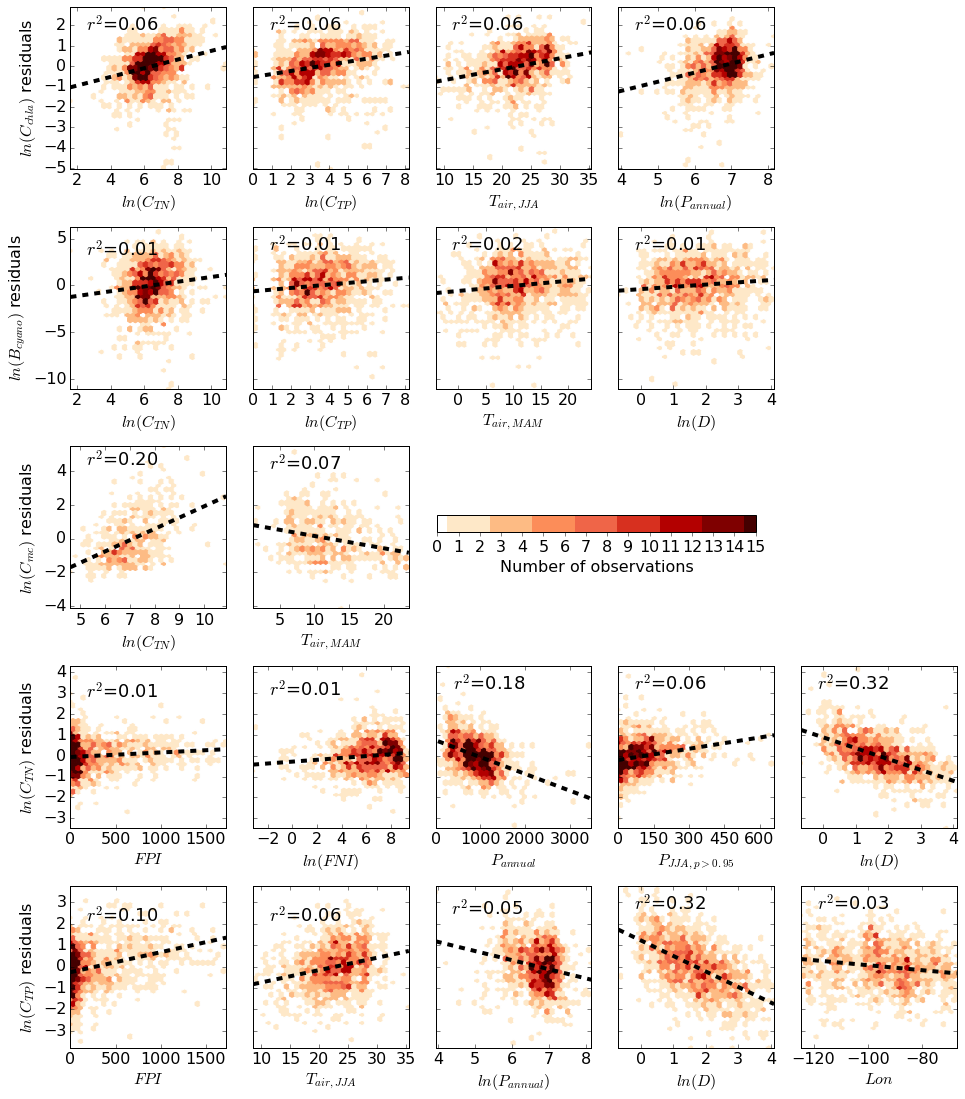

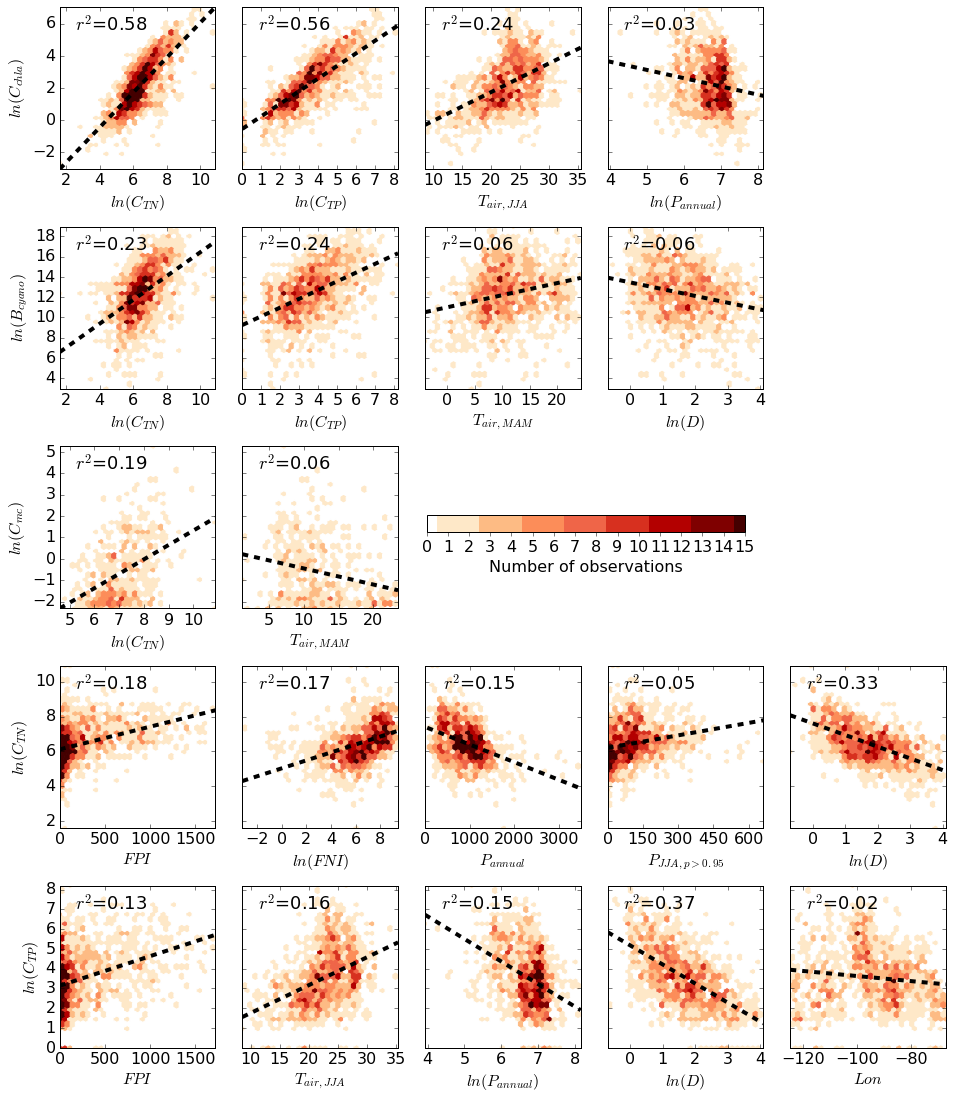

In [36]:
#Fig S1 and S2 linearity of best models

def get_text_xy(axi):
    text_x = float(axi.get_xlim()[0])+(0.1)*np.diff(axi.get_xlim())
    text_y = float(axi.get_ylim()[1])-(0.15)*np.diff(axi.get_ylim())
    return(text_x,text_y)

dict_dispname_fromnames = dict(zip(allvar_names,allvar_disp))
# display(dict_dispname_fromnames)

fig,ax = plt.subplots(5,5,figsize=(13,15),sharey='row')
plt.tight_layout(h_pad=4)
# exes=[[-5,4],[-10,7],[-4,6],[-4,4],[-4,4]]
fig2,ax2 = plt.subplots(5,5,figsize=(13,15),sharey='row')
plt.tight_layout(h_pad=4)

k=0
for whichmodel in ['chla','cybv','mic','tn','tp']:
    print(whichmodel)
    df = dict_meta[whichmodel][0]
    n=len(df)
    
    #get best_ols_vars as a list
#     display(df.head())
    best_models = pd.DataFrame.from_csv(
        'best_models/best_models_{}_{}_{}.csv'.format(whichmodel,whichyear,suff))
    best_models = best_models.sort_values(by='n',ascending=False)
    best_models.loc[:,'BIC_diff'] = np.append(np.diff(best_models['BIC']),np.nan)
    best_row = 0
    BIC_imp_of_best = best_models.iloc[best_row].BIC_diff
    while (BIC_imp_of_best<10):
        best_row+=1
        BIC_imp_of_best = best_models.iloc[best_row].BIC_diff
    print(best_row)
#     display(best_models)
    best_ols_vars = best_models.iloc[best_row].model
    best_ols_vars = ast.literal_eval(best_ols_vars) #need literal eval because otherwise is str
    best_ols_vars = list(best_ols_vars)
    
    #sort best_ols_vars by bma prob:
#     df_prob = pd.DataFrame.from_csv(
#         'bma/bma_{}_{}_{}.csv'.format(whichmodel,whichyear,suff))
#     best_ols_vars = list(df_prob.loc[df_prob['pred_var'].isin(best_ols_vars),'pred_var'].values)
    #sort best_ols_vars by allvar_names_ordered
    best_ols_vars = [varname for varname in allvar_names_ordered if varname in best_ols_vars]
    print(best_ols_vars)
    
    vmax_vis = 15
    num_vars_in_best = len(best_ols_vars)
    
    #get regressionresults object
    def get_mod(i_vars,dafr):
        df_i = dafr[[dict_meta[whichmodel][1]]+i_vars].copy()
        y = df_i[dict_meta[whichmodel][1]]
        X = df_i[i_vars]
        est = get_ols(X,y)
        return [est,df_i]
    [best_ols,best_ols_df] = get_mod(best_ols_vars,df)

    for col_num in range(num_vars_in_best,5):
        ax[k,col_num].remove()
        ax2[k,col_num].remove()
    sp=0
    for varname in best_ols_vars:
        var = best_ols_df[varname]
        obs = best_ols_df[dict_meta[whichmodel][1]]
        #get ols for model without var
        other_vars = [v for v in best_ols_vars if v != varname]
        [best_ols_novar,zzz] = get_mod(other_vars,best_ols_df)
        novar_res = best_ols_novar.resid
        # variable to response variable residual plots for all variables
        x_range = (var.min(),var.max())
        ols1 = get_ols(var,novar_res)
        ols2 = get_ols(var,obs)
        for grouping in [[ols1,novar_res,ax],[ols2,obs,ax2]]:
            olsg = grouping[0]
            yvarg = grouping[1]
            axg = grouping[2]
            hb=axg[k,sp].hexbin(var, yvarg, gridsize=30, cmap=cm,vmin=0,vmax=vmax_vis,
                               extent=[min(var),max(var)]+[min(yvarg),max(yvarg)])#+exes[k])
            axg[k,sp].plot(x_range,get_y_ends(x_range,olsg.params),'k--',lw=4)
            axg[k,sp].set_xlabel(dict_dispname_fromnames[varname],fontsize=16)
#             axg[k,sp].set_xlabel(varname,fontsize=16)
            [tx,ty] = get_text_xy(axg[k,sp])
            axg[k,sp].text(tx,ty,'$r^2$={:.2f}'.format(olsg.rsquared),color='k',fontsize=18)
            axg[k,sp].tick_params(axis='both',labelsize=16)
        sp+=1 
    ax[k,0].set_ylabel('{} residuals'.format(modelnames[k]),fontsize=16)
    ax2[k,0].set_ylabel('{}'.format(modelnames[k]),fontsize=16)
    k+=1
    
# fixing individual plot x-labels and ticks
for axg in [ax,ax2]:
#     axg[3,3].set_xlabel('N fertilizer x\nTotal precip annual (log)',fontsize=13)
#     axg[3,4].set_xlabel('N fertilizer x\nExtreme precip annual (95th)',fontsize=13)
    # ax[4,4].xaxis.set_label_coords(0.4,-0.145)
    axg[3,2].set_xticks(np.arange(0,4000,1000))
    axg[3,3].set_xticks(np.arange(0,700,150))
    for k in [3,4]:
#         axg[k,k].ticklabel_format(style='sci', axis='x', scilimits=(0,0),useMathText=True)
#         axg[k,k].set_xticks(np.arange(200,1600,400))
        axg[k,0].set_xticks(np.arange(0,2000,500))
    axg[4,4].set_xticks(np.arange(-120,-70,20))

    

#legends plus caxis
for figg in [fig,fig2]:
#     cbaxes = figg.add_axes([0.625, 0.5, 0.34, 0.015]) 
    cbaxes = figg.add_axes([0.425, 0.5, 0.34, 0.015]) 
    cb = figg.colorbar(hb,cax=cbaxes,ticks=[0]+range(1,16),orientation='horizontal')
    cb.ax.tick_params(labelsize=16,direction='out') 
    cb.set_label('Number of observations',rotation=0,ha='center',fontsize=16)

plt.figure(1)
# plt.savefig('figures_to_look_at/added_var_plot_v4.png',bbox_inches='tight',dpi=300)
plt.figure(2)
# plt.savefig('figures_to_look_at/correlations_plot_v4.png',bbox_inches='tight',dpi=300)
plt.show()

['[-4.04, 10.6]' '(10.6, 19.07]' '(19.07, 22.9]' '(22.9, 24.2]']
['[8.6, 23.03]' '(23.03, 28]' '(28, 31.1]' '(31.1, 35.4]']
['[50.8, 897]' '(897, 1386]' '(1386, 2175.8]' '(2175.8, 3488.3]']
['[0, 95]' '(95, 248.06]' '(248.06, 415.7]' '(415.7, 661.8]']


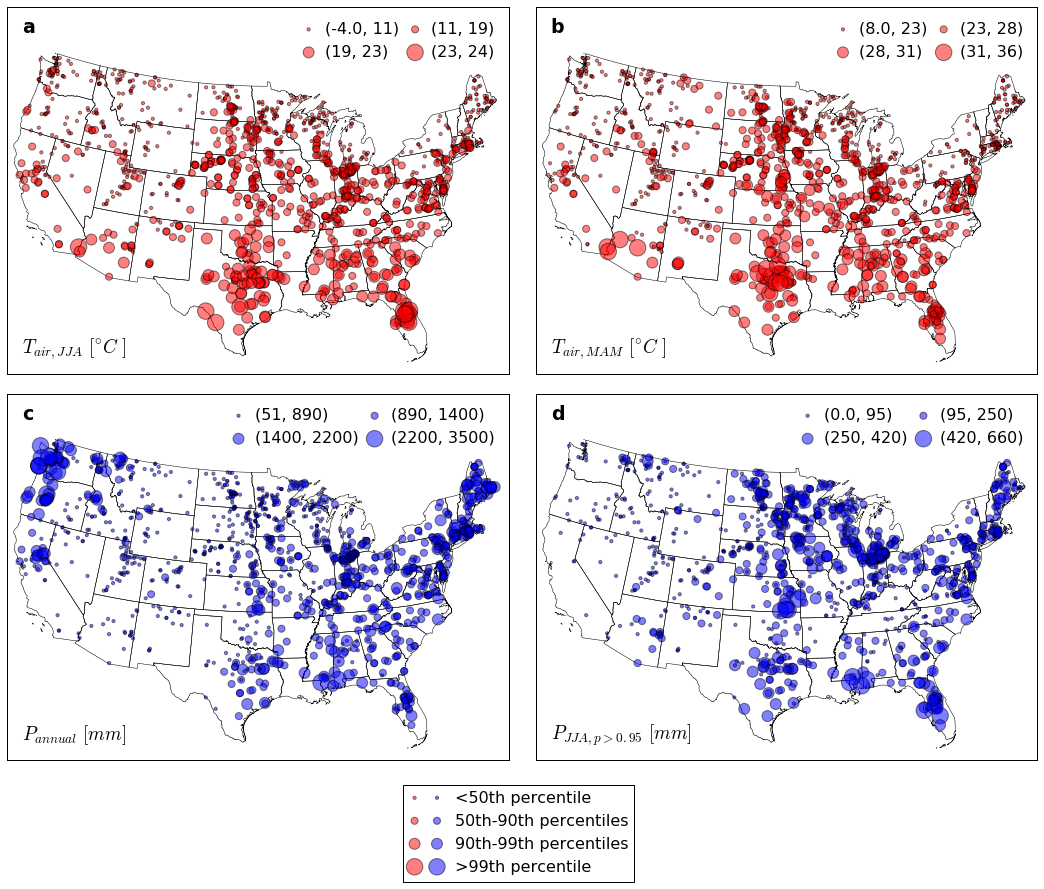

In [23]:
# Fig S3 locations of response variables
fig,ax = plt.subplots(2,2,figsize=(15,11),sharex=True,sharey=True)
plt.tight_layout()
plaxes = [ax[0,0],ax[0,1],ax[1,0],ax[1,1]]
# plaxes = [ax[0,0],ax[1,0],ax[2,0],ax[0,1],ax[1,1],ax[2,1]]
# exes=[[-1,6],[4,18],[0,1],[-3,4],[3,10],[0,7]]
# tx=[[-1,7,1],[4,20,2],[0.0,1.2,0.2],[-3,5,1],[3,11,1],[0,8,1]]

# ['[-4.04, 10.6]' '(10.6, 19.07]' '(19.07, 22.9]' '(22.9, 24.2]']
# ['[8.6, 23.03]' '(23.03, 28]' '(28, 31.1]' '(31.1, 35.4]']
# ['[50.8, 897]' '(897, 1386]' '(1386, 2175.8]' '(2175.8, 3488.3]']
# ['[0, 95]' '(95, 248.06]' '(248.06, 415.7]' '(415.7, 661.8]']

scatter_sizes = [10,50,120,270]
scatter_sizes_leg = [[10,10],[50,50],[120,120],[270,270]]
binstrs_labels =[['(-4.0, 11)', '(11, 19)', '(19, 23)', '(23, 24)'],
               ['(8.0, 23)', '(23, 28)', '(28, 31)', '(31, 36)'],
               ['(51, 890)', '(890, 1400)', '(1400, 2200)', '(2200, 3500)'],
               ['(0.0, 95)', '(95, 250)', '(250, 420)', '(420, 660)']]
binstrs_list = [[-4,10,19,23,24],
                [8,23,28,31,36],
                [50,900,1400,2200,3500],
                [0,95,250,415,665]]
s3_legnames = ['$T_{air,JJA} \  [^{\circ}C\ ]$',
               '$T_{air,MAM} \  [^{\circ}C\ ]$',
               '$P_{annual} \  [mm]$',
               '$P_{JJA,p>0.95} \  [mm]$']
cs=['r','r','b','b']
cs_leg = ['r','b']
#for bw versions
# cs=['grey','grey','grey']
fsize=19
k=0
for whichmodel in ['airtemp_mam','airtemp_jja','prec_tot_ann_mm','E_pr_gt95_jja']:
#     print(whichmodel)
    df = dict_meta['tn'][0] #take the df with the most measurements
    respvar = whichmodel
    dispvar = df[respvar]
    dispvar_cats = pd.qcut(dispvar,q=[0,.5,.9,.99,1],precision=0)
    print(dispvar_cats.cat.categories.values)
    dispvar_cats = pd.cut(dispvar,bins=binstrs_list[k])
#     print(dispvar_cats.head())
    binstrs = dispvar_cats.cat.categories.values
#     print(list(binstrs))
    size_dict = dict(zip(binstrs,scatter_sizes))    
    n=len(df)

    # Create basemap and load US states shapefile
    map = Basemap(llcrnrlon=-119.5,llcrnrlat=25,urcrnrlon=-63.5,urcrnrlat=48.5,
            projection='lcc',lat_1=33,lat_2=45,lon_0=-95)
    map.readshapefile('../USstatesSHP/st99_d00', name='states', drawbounds=True,ax=plaxes[k])

    # Add lon/lat data
    x,y = map(df['lon_dd'].values, df['lat_dd'].values)
    map.scatter(x, y, s=dispvar_cats.map(lambda x: size_dict[x]),#offsets_b[k]+offsets_m[k]*dispvar,
                c=cs[k],alpha=0.5,
                label=whichmodel,zorder=10,ax=plaxes[k])
    
#         mpl.rcParams['legend.scatterpoints'] = 1
    leg_sizes=binstrs_labels[k]
    l1 = plaxes[k].scatter([],[], s=scatter_sizes[0],c=cs[k],alpha=0.5)
    l2 = plaxes[k].scatter([],[], s=scatter_sizes[1],c=cs[k],alpha=0.5)
    l3 = plaxes[k].scatter([],[], s=scatter_sizes[2],c=cs[k],alpha=0.5)
    l4 = plaxes[k].scatter([],[], s=scatter_sizes[3],c=cs[k],alpha=0.5)

    leg = plaxes[k].legend([l1,l3,l2,l4], [leg_sizes[x] for x in [0,2,1,3]], ncol=2, frameon=False,# loc=3,
                           fontsize=16,handletextpad=0.01,columnspacing=0.01)#,title=legnames[k])
    
    if k==2:
        plaxes[k].add_artist(leg)
        l1 = plaxes[k].scatter([],[], s=scatter_sizes_leg[0],c=cs_leg,alpha=0.5)
        l2 = plaxes[k].scatter([],[], s=scatter_sizes_leg[1],c=cs_leg,alpha=0.5)
        l3 = plaxes[k].scatter([],[], s=scatter_sizes_leg[2],c=cs_leg,alpha=0.5)
        l4 = plaxes[k].scatter([],[], s=scatter_sizes_leg[3],c=cs_leg,alpha=0.5)
        leg_sizes = ['<50th percentile','50th-90th percentiles','90th-99th percentiles','>99th percentile']
        leg = plaxes[k].legend([l1,l2,l3,l4], leg_sizes, ncol=1, frameon=True,scatterpoints=2,
                               scatteryoffsets=[0.5],
                               fontsize=16,#,handletextpad=0.01,columnspacing=0.01)#,title=legnames[k])
                               loc='center', bbox_to_anchor=(1.02, -0.2),)
        
    small_x = plaxes[k].get_xlim()[1]*0.03
    small_y = plaxes[k].get_ylim()[1]*-0.08
    big_y = plaxes[k].get_ylim()[1]*1.06
    plaxes[k].text(small_x,big_y,letters[k],color='k',fontsize=fsize,fontweight='bold')
    plaxes[k].text(small_x,small_y,s3_legnames[k],color='k',fontsize=fsize)
    k+=1

# plt.savefig('figures_to_look_at/map_clim_vars_bins.png',bbox_inches='tight',dpi=300)
# plt.savefig('figures_to_look_at/map_clim_vars_bins.pdf',bbox_inches='tight',dpi=300)
plt.show()


['In situ nutrients' 'Nutrient input' 'Nutrient loading' 'Precipitation'
 'Temperature' 'Other(s)' 'Drought severity' 'Stratification']
1


model  \
3780858  ['TN_tn_log', 'TP_tp_log', 'airtemp_jja', 'area_ha_log', 'prec_tot_ann_mm_log']   
302297                  ['TN_tn_log', 'TP_tp_log', 'airtemp_jja', 'prec_tot_ann_mm_log']   
17538                                            ['TN_tn_log', 'TP_tp_log', 'temp_surf']   
654                                                           ['TN_tn_log', 'TP_tp_log']   
11                                                                         ['TN_tn_log']   

               R2          BIC  n    BIC_diff  
3780858  0.692032  3247.177467  5    8.209467  
302297   0.688261  3255.386934  4   55.457640  
17538    0.672395  3310.844574  3  126.259869  
654      0.635839  3437.104443  2  181.137566  
11       0.577197  3618.242009  1         NaN

1


model  \
3782049  ['TN_tn_log', 'TP_tp_log', 'airtemp_mam', 'depth_m_log', 'lat_dd']   
302320             ['TN_tn_log', 'TP_tp_log', 'airtemp_mam', 'depth_m_log']   
17496                             ['TN_tn_log', 'TP_tp_log', 'airtemp_mam']   
654                                              ['TN_tn_log', 'TP_tp_log']   
13                                                            ['TP_tp_log']   

               R2          BIC  n   BIC_diff  
3782049  0.293596  5424.892044  5   6.721829  
302320   0.285513  5431.613873  4  13.597155  
17496    0.273236  5445.211028  3  15.125324  
654      0.259818  5460.336351  2  34.581002  
13       0.233983  5494.917353  1        NaN

3


model  \
561777  ['DOY_COL', 'E_pr_gt90_mam', 'TN_tn_log', 'airtemp_jja', 'cur_NAPI_FERT_log']   
134589             ['E_pr_gt90_mam', 'TN_tn_log', 'airtemp_jja', 'cur_NAPI_FERT_log']   
17705                             ['TN_tn_log', 'airtemp_mam', 'prec_tot_mam_mm_log']   
658                                                      ['TN_tn_log', 'airtemp_mam']   
11                                                                      ['TN_tn_log']   

              R2          BIC  n   BIC_diff  
561777  0.289342  1666.324308  5  -1.528553  
134589  0.282682  1664.795755  4  -0.131926  
17705   0.273947  1664.663828  3   2.015459  
658     0.261960  1666.679287  2  34.384802  
11      0.199910  1701.064088  1        NaN

0


model  \
3420351  ['cur_NANI_FERT_log', 'depth_m_log', 'flux_NFERTxE_pr_gt95', 'flux_NFERTxprec_tot_ann_mm_log', '...   
153805                              ['E_pr_gt95_jja', 'cur_NANI_FERT_log', 'depth_m_log', 'prec_tot_ann_mm']   
24603                                             ['depth_m_log', 'flux_NFERTxE_pr_gt90', 'prec_tot_ann_mm']   
862                                                                         ['cur_NANI_FERT', 'depth_m_log']   
25                                                                                           ['depth_m_log']   

               R2          BIC  n    BIC_diff  
3420351  0.583765  2737.686428  5   29.527036  
153805   0.571542  2767.213465  4   92.899618  
24603    0.536339  2860.113082  3  192.508212  
862      0.457204  3052.621295  2  260.357059  
25       0.329608  3312.978353  1         NaN

0


model  \
2950242  ['airtemp_jja', 'cur_NAPI_FERT', 'depth_m_log', 'lon_dd', 'prec_tot_ann_mm_log']   
271192      ['airtemp_mam', 'depth_m_log', 'flux_PFERTxE_pr_gt95', 'prec_tot_ann_mm_log']   
20271                             ['cur_NANI_FERT', 'depth_m_log', 'prec_tot_ann_mm_log']   
1149                                               ['depth_m_log', 'prec_tot_ann_mm_log']   
25                                                                        ['depth_m_log']   

               R2          BIC  n    BIC_diff  
2950242  0.571752  3569.098845  5   41.635336  
271192   0.554943  3610.734181  4   53.834711  
20271    0.532999  3664.568891  3  184.813183  
1149     0.456605  3849.382074  2  189.144487  
25       0.365549  4038.526561  1         NaN

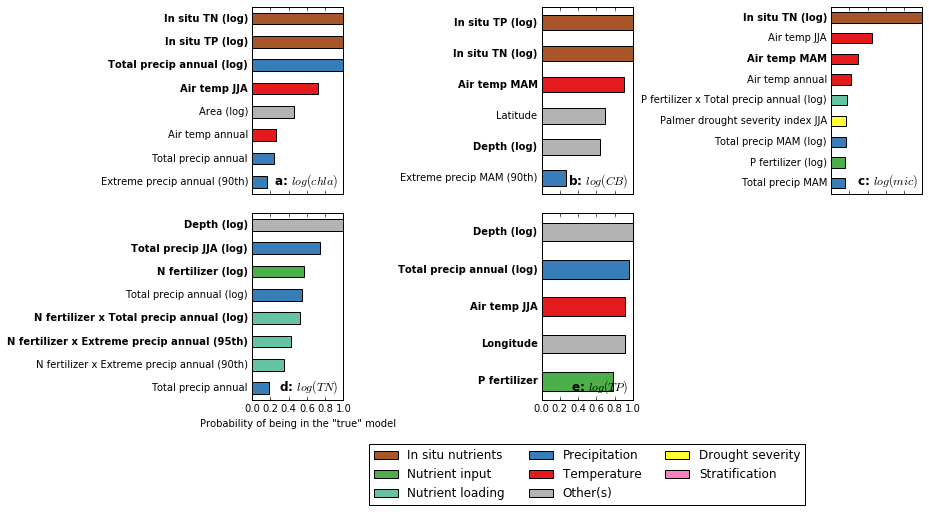

In [8]:
# Individual variable BMA scores

# get categories/colors (switching the order of this dict changes the order of the legend)
#set 1
# dict_cats = [
#     ('In situ TN',['#a65628','TN_']),
#     ('In situ TP',['#e5c494','TP_']),
#     ('Nutrient input',['#4daf4a','cur_']),
#     ('Nutrient loading',['#66c2a5','flux_']),
#     ('Precip total',['#377eb8','prec_']),
#     ('Precip extreme',['#8da0cb','E_']),
#     ('Air temp',['#ffffb3','airtemp_']),
#     ('Drought severity',['#ffff33','pdsi_']),
#     ('Water temp',['#e41a1c','temp_']),
#     ('Stratification',['#f781bf','strat_']),
#     ('Other(s)',['#b3b3b3','XXX']),
# ]
#set 2
allvar_renames = ['prec_'+x if x.startswith('E_') else x for x in allvar_renames]
allvar_renames = ['temp_'+x if x.startswith('airtemp_') else x for x in allvar_renames]
dict_cats = [ # set2
    ('In situ nutrients',['#a65628','T']),
    ('Nutrient input',['#4daf4a','cur_']),
    ('Nutrient loading',['#66c2a5','flux_']),
    ('Precipitation',['#377eb8','prec_']),
    ('Temperature',['#e41a1c','temp_']),
    ('Other(s)',['#b3b3b3','XXX']),
    ('Drought severity',['#ffff33','pdsi_']),
    ('Stratification',['#f781bf','strat_']),
]
dict_cats = collections.OrderedDict(dict_cats)
df_cats = pd.DataFrame.from_dict(dict_cats,orient='index')
df_cats.columns = ['color','prefix']
# display(df_cats)

dict_rename = dict(zip(allvar_names,allvar_renames))
# display(dict_rename)
dict_dispname = dict(zip(allvar_renames,allvar_disp))
# display(dict_dispname)

# functions used in each subplot
allcat_names = df_cats.index.values
print(allcat_names)
def get_cat(pred_var):
    for cat in allcat_names:
        if pred_var.startswith(df_cats.loc[cat,'prefix']):
            return cat
    return 'Other(s)'
def return_bma(whichmodel,prob_thresh=None,num_entries=None,suff_suff=''):
    new_suff = suff+suff_suff
    df_prob = pd.DataFrame.from_csv(
        'bma/bma_{}_{}_{}.csv'.format(whichmodel,whichyear,new_suff))
    df_prob.loc[:,'pred_var_rn'] = df_prob['pred_var'].map(lambda x: dict_rename[x])
    df_prob.loc[:,'cat'] = df_prob['pred_var_rn'].map(get_cat)
    df_prob.loc[:,'disp_name'] = df_prob['pred_var_rn'].map(lambda x: dict_dispname[x])
    df_prob.loc[:,'color'] = df_prob['cat'].map(lambda x: df_cats.loc[x,'color'])
    df_prob.loc[:,'idx'] = range(0,len(df_prob))
    df_prob.set_index('disp_name',inplace=True)
    if prob_thresh is None:
        if num_entries is None:
            df_prob = df_prob #if both are None, return full bma
        else:
            df_prob = df_prob.iloc[0:num_entries]
    else:
        if num_entries is None:
            df_prob = df_prob.loc[df_prob['prob']>prob_thresh]
        else:
            raise ValueError(
                'Cannot pass values for both prob_thresh and num_entries. Values:',
                prob_thresh,num_entries)
#     display(df_prob)
    # print(len(df_prob))
    return df_prob.sort_values('prob',ascending=False)
df_all_probs = return_bma('chla')#,prob_thresh=0

# FINALLY, plotting for all variables!
fig,ax = plt.subplots(2,3,figsize=(10,6),sharex=True)
plt.tight_layout(w_pad=17) # adjust w_pad so that variable names don't overlap
plaxes = [ax[0,0],ax[0,1],ax[0,2],ax[1,0],ax[1,1],ax[1,2]]
k=0
prob_t = 0.15
for whichmodel in ['chla','cybv','mic','tn','tp']:
    best_models = pd.DataFrame.from_csv(
        'best_models/best_models_{}_{}_{}.csv'.format(whichmodel,whichyear,suff))
    best_models = best_models.sort_values(by='n',ascending=False)
    best_models.loc[:,'BIC_diff'] = np.append(np.diff(best_models['BIC']),np.nan)
    best_row = 0
    BIC_imp_of_best = best_models.iloc[best_row].BIC_diff
    while (BIC_imp_of_best<10):
        best_row+=1
        BIC_imp_of_best = best_models.iloc[best_row].BIC_diff
    print(best_row)
    display(best_models)
    best_ols_vars = best_models.iloc[best_row].model
    best_ols_vars = list(ast.literal_eval(best_ols_vars)) 
#     print(best_ols_vars)
    best_model_r2 = best_models.iloc[0]['R2']
    
    # plot individual top variables by bma
    df_probs = return_bma(whichmodel,prob_thresh=prob_t)#,num_entries=8)
#     display(df_probs)
    df_probs['prob'].plot.barh(ax=plaxes[k],color=list(df_probs['color'])) 
    plaxes[k].invert_yaxis()
    plaxes[k].set_ylabel('')
    plaxes[k].tick_params(axis='y',left='off',right='off')
    yticklabs = plaxes[k].get_yticklabels()
    for l in best_ols_vars:
        i = list(df_probs['pred_var'].values).index(l)
        yticklabs[i].set_fontweight("bold")
    
    big_y = -0.5+len(df_probs)*0.95
    plaxes[k].text(0.95,big_y,'{}: {}'.format(letters[k],modelnames[k]),
                   ha='right',color='k',fontsize=12,fontweight='bold')
    k+=1
plaxes[5].remove()
    
#create fake plot for legend
for catname in allcat_names: 
    df_probs_cat = df_all_probs.loc[df_all_probs['cat']==catname]
#     display(df_probs_cat)
    plaxes[k-1].barh(df_probs_cat['idx']+100,df_probs_cat['prob'],height=0.6,
                   align='center',label=catname,color=df_probs_cat['color'])
h, l = plaxes[k-1].get_legend_handles_labels() # remove first entry 
# plaxes[k-1].legend(h[1:],l[1:],ncol=3,loc='center',bbox_to_anchor=(-0.78,-0.4))
# plaxes[k-1].legend(h[1:],l[1:],ncol=1,loc='center',bbox_to_anchor=(1.75,1.05))
plaxes[k-1].legend(h[1:],l[1:],ncol=3,loc='center',bbox_to_anchor=(0.5,-0.4))
    
for k in [k-3,k-2]:
    plaxes[k].set_xlabel('Probability of being in the "true" model')

plt.savefig('figures_to_look_at/bma_5_allvars_pres.png',bbox_inches='tight',dpi=300)
plt.show()
# SAVE ONCE ADDING VARIABLE NAMES TO LEGEND. IF ANNA WANTS THIS, AFTER ALL.

# # plotting just tn and tp
# fig,ax = plt.subplots(1,2,figsize=(7,3),sharex=True)
# plt.tight_layout(w_pad=13) # adjust w_pad so that variable names don't overlap
# plaxes = [ax[0],ax[1]]
# k=0
# for whichmodel in ['tn','tp']:
#     # get best models
#     best_models = pd.DataFrame.from_csv(
#         'best_models/best_models_{}_{}_{}.csv'.format(whichmodel,whichyear,suff))
#     best_models = best_models.sort_values(by='BIC')
#     best_ols_vars = best_models.iloc[0].model
#     best_ols_vars = list(ast.literal_eval(best_ols_vars)) 
# #     print(best_ols_vars)
#     best_model_r2 = best_models.iloc[0]['R2']
    
#     # plot individual top variables by bma
#     df_probs = return_bma(whichmodel,prob_thresh=prob_t)#,num_entries=8)
# #     display(df_probs)
#     df_probs['prob'].plot.barh(ax=plaxes[k],color=list(df_probs['color'])) 
#     plaxes[k].invert_yaxis()
#     plaxes[k].set_ylabel('')
#     plaxes[k].tick_params(axis='y',left='off',right='off')
#     yticklabs = plaxes[k].get_yticklabels()
#     for l in best_ols_vars:
#         i = list(df_probs['pred_var'].values).index(l)
#         yticklabs[i].set_fontweight("bold")
    
#     big_y = -0.5+len(df_probs)*0.95
#     plaxes[k].text(0.95,big_y,'{}: {}'.format(letters[k],modelnames[k+3]),
#                    ha='right',color='k',fontsize=12,fontweight='bold')
#     k+=1
    
# #create fake plot for legend
# for catname in [allc for allc in allcat_names if allc!='In situ nutrients']: 
#     df_probs_cat = df_all_probs.loc[df_all_probs['cat']==catname]
#     plaxes[k-1].barh(df_probs_cat['idx']+100,df_probs_cat['prob'],height=0.6,
#                    align='center',label=catname,color=df_probs_cat['color'])
# h, l = plaxes[k-1].get_legend_handles_labels() # remove first entry 
# # plaxes[k-1].legend(h[1:],l[1:],ncol=3,loc='center',bbox_to_anchor=(-0.55,-0.4))
# plaxes[k-1].legend(h[1:],l[1:],ncol=1,loc='center',bbox_to_anchor=(1.6,0.5))
    
# for k in [k-2,k-1]:
#     plaxes[k].set_xlabel('Probability of being in the "true" model')

# # plt.savefig('figures_to_look_at/bma_2_tntp_pres.png',bbox_inches='tight',dpi=300)
# plt.show()

In [ ]:
# # FINALLY, plotting for no tntp!
# fig,ax = plt.subplots(2,2,figsize=(7,6),sharex=True)
# plt.tight_layout(w_pad=22) # adjust w_pad so that variable names don't overlap
# plaxes = [ax[0,0],ax[0,1],ax[1,0],ax[1,1]]
# k=0
# prob_t = 0.15
# for whichmodel in ['chla','cybv','mic','mic']:#,'tn','tp']:
#     # get best models
#     suff2 = ''
#     if whichmodel in ['chla','cybv','cypro','mic']:
#         suff2 = 'noinsitunogm'
#     best_models = pd.DataFrame.from_csv(
#         'best_models/best_models_{}_{}_{}.csv'.format(whichmodel,whichyear,suff+suff2))
#     best_models = best_models.sort_values(by='BIC')
#     best_ols_vars = best_models.iloc[0].model
#     best_ols_vars = list(ast.literal_eval(best_ols_vars)) 
# #     print(best_ols_vars)
#     best_model_r2 = best_models.iloc[0]['R2']
    
#     # plot individual top variables by bma
#     df_probs = return_bma(whichmodel,num_entries=12,suff_suff=suff2)#prob_thresh=prob_t)
# #     display(df_probs)
#     df_probs['prob'].plot.barh(ax=plaxes[k],color=list(df_probs['color'])) 
#     # if want more customizability e.g., bar widths etc.
# #     for catname in allcat_names: #['Air temp']
# #         df_probs_cat = df_probs.loc[df_probs['cat']==catname]
# #         plaxes[k].barh(df_probs_cat['idx'],df_probs_cat['prob'],height=0.6,
# #                        align='center',label=catname,color=df_probs_cat['color'])
# #     plaxes[k].set_yticks(df_probs['idx'])
# #     plaxes[k].set_yticklabels(df_probs.index.values)
# #     plaxes[k].set_ylim([-0.75,len(df_probs)-0.25])
#     plaxes[k].invert_yaxis()
#     plaxes[k].set_ylabel('')
#     plaxes[k].tick_params(axis='y',left='off',right='off')
#     yticklabs = plaxes[k].get_yticklabels()
#     for l in best_ols_vars:
#         i = list(df_probs['pred_var'].values).index(l)
#         yticklabs[i].set_fontweight("bold")
    
#     big_y = -0.5+len(df_probs)*0.95
#     plaxes[k].text(0.95,big_y,'{}: {}'.format(letters[k],modelnames[k]),
#                    ha='right',color='k',fontsize=12,fontweight='bold')
#     k+=1
    
# #create fake plot for legend
# for catname in [allc for allc in allcat_names if allc!='In situ nutrients']: 
#     df_probs_cat = df_all_probs.loc[df_all_probs['cat']==catname]
# #     display(df_probs_cat)
#     plaxes[k-1].barh(df_probs_cat['idx']+100,df_probs_cat['prob'],height=0.6,
#                    align='center',label=catname,color=df_probs_cat['color'])
# h, l = plaxes[k-1].get_legend_handles_labels() # remove first entry 
# plaxes[k-1].legend(h[1:],l[1:],ncol=3,loc='center',bbox_to_anchor=(-1.23,-0.4))
# # (if not using pandas.plot above, need to remove more than first entry)
# # plaxes[k-1].legend(h[1:],l[1:],ncol=1,loc='center',bbox_to_anchor=(2,1.05))
  
# for k in [k-2,k-1]:
#     plaxes[k].set_xlabel('Probability of being in the "true" model')
# plaxes[2].remove()

# # plt.savefig('figures_to_look_at/bma_4_notntp.png',bbox_inches='tight',dpi=300)
# # plt.savefig('figures_to_look_at/bma_4_nometnoflux.png',bbox_inches='tight',dpi=300)
# # plt.savefig('figures_to_look_at/bma_4_nometnofluxnollpdsi.png',bbox_inches='tight',dpi=300)
# # plt.savefig('figures_to_look_at/bma_4_noinsitunogm.png',bbox_inches='tight',dpi=300)
# plt.show()

chla
cybv
mic
tn
tp


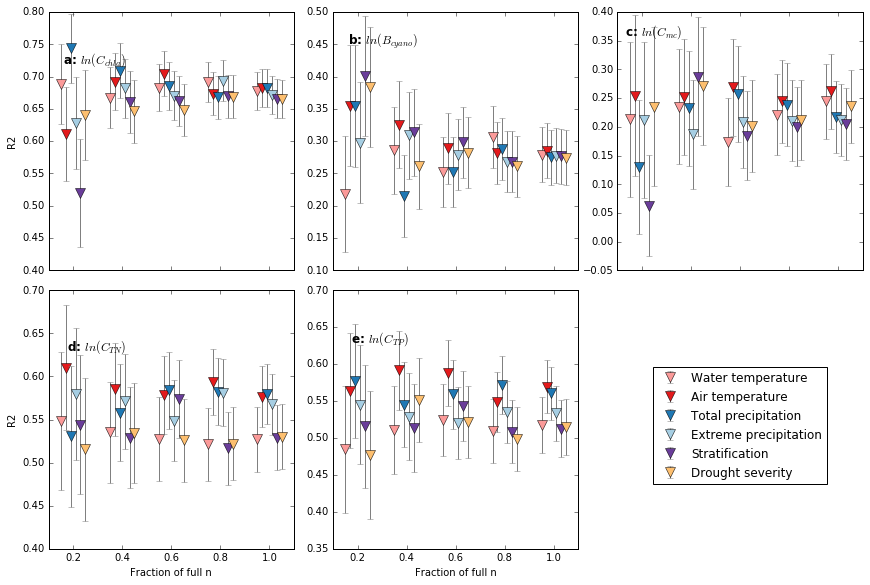

In [74]:
# Fig 4 R2 and 95% CIs for models with specific variables in them.

dict_colors = {
    'justairtemp':'#e31a1c',#'red',
    'justwattemp':'#fb9a99',#'orange',
    'justpreciptot':'#1f78b4',#'blue',
    'justprecipex':'#a6cee3',#'cyan',
    'juststrat':'#6a3d9a',#'#f781bf',
    'justpdsi':'#fdbf6f',#'#ffff33',
}

#for HABs
fig,ax = plt.subplots(2,3,figsize=(12,8),sharex=True)
plaxes = [ax[0,0],ax[0,1],ax[0,2],ax[1,0],ax[1,1],ax[1,2]]
plt.tight_layout()
k=0
# n_to_show=4
n_dict = {'chla':4,
          'cybv':4,
          'mic':2,
          'tn':5,
          'tp':5}
for whichmodel in ['chla','cybv','mic','tn','tp']:
    print(whichmodel)
    df = dict_meta[whichmodel][0]
    n=len(df)
#     n_to_show = 2 if ('mic' in whichmodel) else 4
    n_to_show = n_dict[whichmodel]

    #get best_ols_vars as a list
    def get_best_vars(suff_suff,num_vars):
        best_models = pd.DataFrame.from_csv(
            'best_models/best_models_{}_{}_{}.csv'.format(whichmodel,whichyear,suff+suff_suff))
        best_vars = best_models.loc[best_models['n']==num_vars].iloc[0].model
#         display(best_models.loc[best_models['n']==num_vars].iloc[0])
        best_vars = ast.literal_eval(best_vars) #need literal eval because otherwise is str
        best_vars = list(best_vars)
        return best_vars
    
    #get regressionresults object
    def get_mod(i_vars,dafr,samplefrac=1.0):
        df_i = dafr[[dict_meta[whichmodel][1]]+i_vars].sample(frac=samplefrac,replace=False)
        y = df_i[dict_meta[whichmodel][1]]
        X = df_i[i_vars]
        est = get_ols(X,y)
        return [est,df_i]
    
#     xes = np.arange(n_to_show,n_to_show+1,1.0)
    xes = np.arange(1,6,1.0)
    # loop through different suff_suffs to load different best_models
    i=0.0
    for sub in ['justwattemp','justairtemp','justpreciptot','justprecipex',
                'juststrat','justpdsi']:
        sub_ys = []
        sub_yerrs = []
        k_sub=n_to_show
        for frac in [0.2,0.4,0.6,0.8,1.0]:
            best_ols_vars = get_best_vars(sub+'2',k_sub)
#             best_ols_vars = get_best_vars(sub+'2_notntp',k_sub)
#             if k_sub in [4,5]:
#             display(best_ols_vars)
            [best_ols_sub,best_ols_sub_df] = get_mod(best_ols_vars,df,frac)
            r2 = best_ols_sub.rsquared
            sub_ys.append(r2)
            n_frac = len(best_ols_sub_df)
            ser2 = np.sqrt( 
                4*r2*((1-r2)**2)*((n_frac-k_sub-1)**2)/(((n_frac**2)-1)*(n_frac+3)) )
            sub_yerrs.append(1.96*ser2)
#         display(best_ols_vars)
#         print(r2)

        bg_col = dict_colors[sub]
        xes_jit = xes-0.25+(i/5)*0.5
        plaxes[k].errorbar(xes_jit,sub_ys,yerr=sub_yerrs,marker='v',ms=10,ls=' ',label=sub,
                       mfc=bg_col,mec='k',ecolor='grey')
        i+=1.0
#     plaxes[k].set_xlabel('Number of variables')

    #set axes, ticks, etc.
    plaxes[k].set_xlim([0.5,n_to_show+0.5])
    plaxes[k].set_xticklabels([0.0,0.2,0.4,0.6,0.8,1.0])
    
    #text
    big_y = 0.9*plaxes[k].get_ylim()[1]
    small_x = 0.5+0.075*n_to_show
    plaxes[k].text(small_x,big_y,'{}: {}'.format(letters[k],modelnames[k]),
                   ha='left',color='k',fontsize=12,fontweight='bold')
    
    k+=1
plaxes[0].set_ylabel('R2')
plaxes[3].set_ylabel('R2')
# plaxes[3].set_xlabel('Number of variables')
# plaxes[4].set_xlabel('Number of variables')
plaxes[3].set_xlabel('Fraction of full n')
plaxes[4].set_xlabel('Fraction of full n')
# plaxes[0].text(1.9,0.51,'(In situ TN\nor TP,\nVariable)',ha='center',va='top')
# plaxes[0].text(3.1,0.58,'(In situ TN,\nIn situ TP,\nVariable)',ha='center',va='top')
# plaxes[1].text(1.9,0.17,'(In situ TN\nor TP,\nVariable)',ha='center',va='top')
# plaxes[1].text(3.1,0.21,'(In situ TN,\nIn situ TP,\nVariable)',ha='center',va='top')
# plaxes[2].text(2,0.13,'(In situ TN,\nVariable)',ha='center',va='top')
h, l = plaxes[2].get_legend_handles_labels()
l = ['Water temperature','Air temperature','Total precipitation','Extreme precipitation',
     'Stratification','Drought severity']
# ax[2].legend([h[3]]+h[0:3]+h[4:6],l,loc='center',bbox_to_anchor=(1.5,0.5))
plaxes[2].legend(h,l,ncol=1,loc='center',bbox_to_anchor=(0.5,-0.6))
plaxes[5].remove()

# plt.savefig('figures_to_look_at/best_vars_habs_R2_notntp.png',bbox_inches='tight',dpi=300)
# plt.savefig('figures_to_look_at/best_vars_5_R2.png',bbox_inches='tight',dpi=300)
plt.show()

In [4]:
# #for TN and TP
# fig,ax = plt.subplots(1,2,figsize=(8,4),sharex=True)
# plt.tight_layout()
# k=0
# n_to_show=5
# for whichmodel in ['tn','tp']:
#     print(whichmodel)
#     df = dict_meta[whichmodel][0]
#     n=len(df)

#     #get best_ols_vars as a list
#     def get_best_vars(suff_suff,num_vars):
#         best_models = pd.DataFrame.from_csv(
#             'best_models/best_models_{}_{}_{}.csv'.format(whichmodel,whichyear,suff+suff_suff))
#         best_vars = best_models.loc[best_models['n']==num_vars].iloc[0].model
#         display(best_models.loc[best_models['n']==num_vars].iloc[0])
#         best_vars = ast.literal_eval(best_vars) #need literal eval because otherwise is str
#         best_vars = list(best_vars)
#         return best_vars
    
#     #get regressionresults object
#     def get_mod(i_vars,dafr):
#         df_i = dafr[[dict_meta[whichmodel][1]]+i_vars].copy()
#         y = df_i[dict_meta[whichmodel][1]]
#         X = df_i[i_vars]
#         est = get_ols(X,y)
#         return [est,df_i]
    
#     xes = np.arange(1.0,n_to_show+1,1.0)
#     # loop through different suff_suffs to load different best_models
#     i=0.0
#     for sub in ['justwattemp','justairtemp','justpreciptot','justprecipex',
#                 'juststrat','justpdsi']:
#         sub_ys = []
#         sub_yerrs = []
#         for k_sub in range(1,n_to_show+1):
#             best_ols_vars = get_best_vars(sub+'3',k_sub)
# #             if k_sub in [4,5]:
# #                 display(best_ols_vars)
#             [best_ols_sub,best_ols_sub_df] = get_mod(best_ols_vars,df)
#             r2 = best_ols_sub.rsquared
#             sub_ys.append(r2)
#             ser2 = np.sqrt( 4*r2*((1-r2)**2)*((n-k_sub-1)**2)/(((n**2)-1)*(n+3)) )
#             sub_yerrs.append(1.96*ser2)

#         bg_col = dict_colors[sub]
#         xes_jit = xes-0.25+(i/5)*0.5
#         ax[k].errorbar(xes_jit,sub_ys,yerr=sub_yerrs,marker='v',ms=10,ls=' ',label=sub,
#                        mfc=bg_col,mec='k',ecolor='grey')
#         i+=1.0
#     ax[k].set_xlabel('Number of variables')

#     #set axes, ticks, etc.
#     ax[k].set_xlim([0.5,n_to_show+0.5])
#     ax[k].set_xticks(range(1,n_to_show+1))
    
#     #text
#     big_y = 0.9*ax[k].get_ylim()[1]
#     small_x = 0.5+0.075*n_to_show
#     ax[k].text(small_x,big_y,'{}: {}'.format(letters[k],modelnames[k+3]),
#                    ha='left',color='k',fontsize=12,fontweight='bold')
    
#     k+=1
# ax[0].set_ylabel('R2')
# ax[0].text(2,0.27,'(N Fert or\nDepth,\nVariable)',ha='center',va='top')
# ax[0].text(3,0.39,'(N Fert,\nDepth,\nVariable)',ha='center',va='top')
# ax[1].text(2,0.3,'(Depth,\nVariable)',ha='center',va='top')
# ax[1].text(3,0.39,'(N or\nP Fert,\nDepth,\nVariable)',ha='center',va='top')
# h, l = ax[1].get_legend_handles_labels()
# l = ['Water temp','Air temp','Precip total','Precip extreme',
#      'Stratification','Drought severity']
# ax[1].legend(h,l,ncol=3,loc='center',bbox_to_anchor=(-0.075,-0.25))

# # plt.savefig('figures_to_look_at/best_vars_tntp_R2.png',bbox_inches='tight',dpi=300)
# plt.show()

flux_NFERTxE_pr_gt95


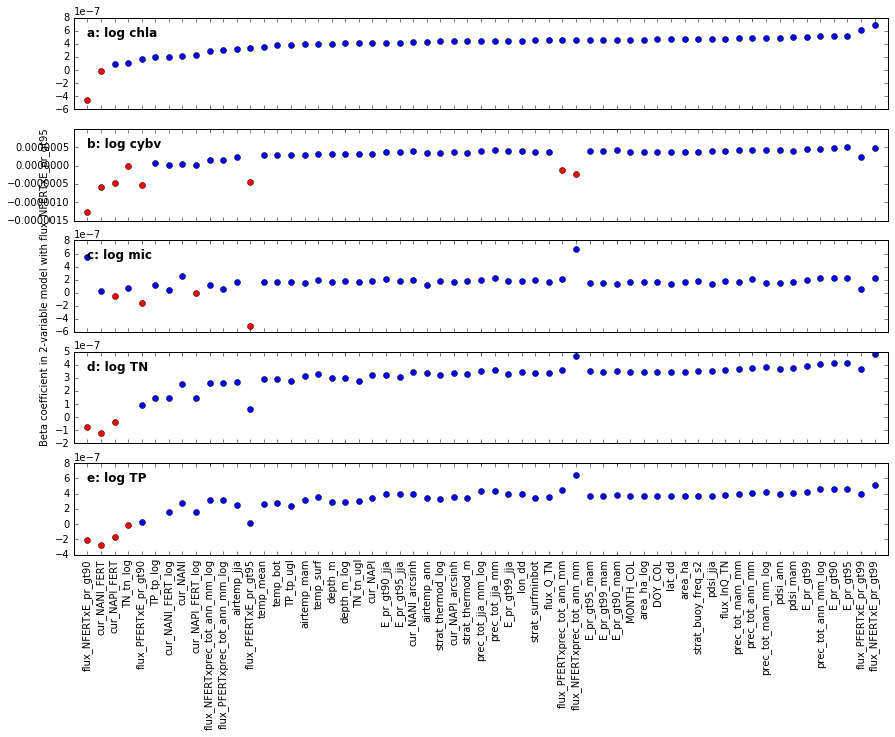

In [3]:
#Fig 6. variation in betas in 2variable models for temp, precip, strat, and drought severity

# for var in ['prec_tot_ann_mm', 'prec_tot_ann_mm_log', 'prec_tot_jja_mm', 
#             'prec_tot_jja_mm_log', 'prec_tot_mam_mm', 'prec_tot_mam_mm_log', 
#             'flux_NFERTxprec_tot_ann_mm', 'flux_NFERTxprec_tot_ann_mm_log', 
#             'flux_PFERTxprec_tot_ann_mm', 'flux_PFERTxprec_tot_ann_mm_log', ]:
# for var in ['E_pr_gt90', 'E_pr_gt90_jja', 'E_pr_gt90_mam', 
#             'E_pr_gt95', 'E_pr_gt95_jja', 'E_pr_gt95_mam', 
#             'E_pr_gt99', 'E_pr_gt99_jja', 'E_pr_gt99_mam', 
#             'flux_NFERTxE_pr_gt90', 'flux_NFERTxE_pr_gt95', 'flux_NFERTxE_pr_gt99', 
#             'flux_PFERTxE_pr_gt90', 'flux_PFERTxE_pr_gt95', 'flux_PFERTxE_pr_gt99',]
# for var in ['temp_bot','temp_surf','temp_mean']:
# for var in ['airtemp_ann', 'airtemp_jja', 'airtemp_mam']:
# for var in ['TN_tn_log','TN_tn_ugl','TP_tp_log','TP_tp_ugl']: # if do this, then need to change import csv
for var in ['flux_NFERTxE_pr_gt95']:
    print(var)
    fig,ax = plt.subplots(5,1,figsize=(12,8),sharex=True)
    plt.tight_layout()
    xlabs = []
    k=0
    for whichmodel in ['chla','cybv','mic','tn','tp']:
#         print(whichmodel)
    
        df_betas = pd.DataFrame.from_csv(
            'betas_2var/betas_2var_{}_{}_{}.csv'.format(whichmodel,whichyear,suff)) #add _tntponly in string
        #sort rows in ascending order
        if len(xlabs)==0:
            df_plot = pd.DataFrame(df_betas[var].sort_values(ascending=True).copy())
            df_plot.reset_index(inplace=True)
            xlabs = df_plot['index'].values
#             display(xlabs)
        else:
            df_plot = pd.DataFrame(df_betas.loc[xlabs,var].copy())
#             display(df_plot)
        df_plot.loc[:,'idx'] = range(1,len(df_plot)+1)
        df_plot.set_index('idx',inplace=True)
#         display(df_plot)
        df_plot_pos = df_plot.loc[df_plot[var]>0]
        df_plot_neg = df_plot.loc[df_plot[var]<0]
        if len(df_plot_pos)>len(df_plot_neg):
            pos_style = 'bo'
            neg_style = 'ro'
        else:
            pos_style = 'ro'
            neg_style = 'bo'
        if len(df_plot_neg)>0:
            df_plot_neg[var].plot(style=neg_style,ax=ax[k])
        if len(df_plot_pos)>0:
            df_plot_pos[var].plot(style=pos_style,ax=ax[k])

        #set axes, ticks, etc.
        ax[k].set_xlim([0,60])
        ax[k].set_xticks(range(1,60))
        
        #text
        big_y = ax[k].get_ylim()[0]+0.8*np.diff(ax[k].get_ylim())
        ax[k].text(1,big_y,'{}: {}'.format(letters[k],modelnames[k]),
                       ha='left',color='k',fontsize=12,fontweight='bold')

        k+=1

    ax[2].set_ylabel('Beta coefficient in 2-variable model with {}'.format(var))
    ax[4].set_xticklabels(xlabs,rotation=90)
    ax[4].set_xlabel('')
#     h, l = ax[0].get_legend_handles_labels()
#     l = ['Negative beta','Positive beta']
#     ax[0].legend([h[0],h[-1]],l,ncol=2,loc=8)

#     plt.savefig('figures_to_look_at/betas/betas_{}.png'.format(var),bbox_inches='tight',dpi=300)
    plt.show()

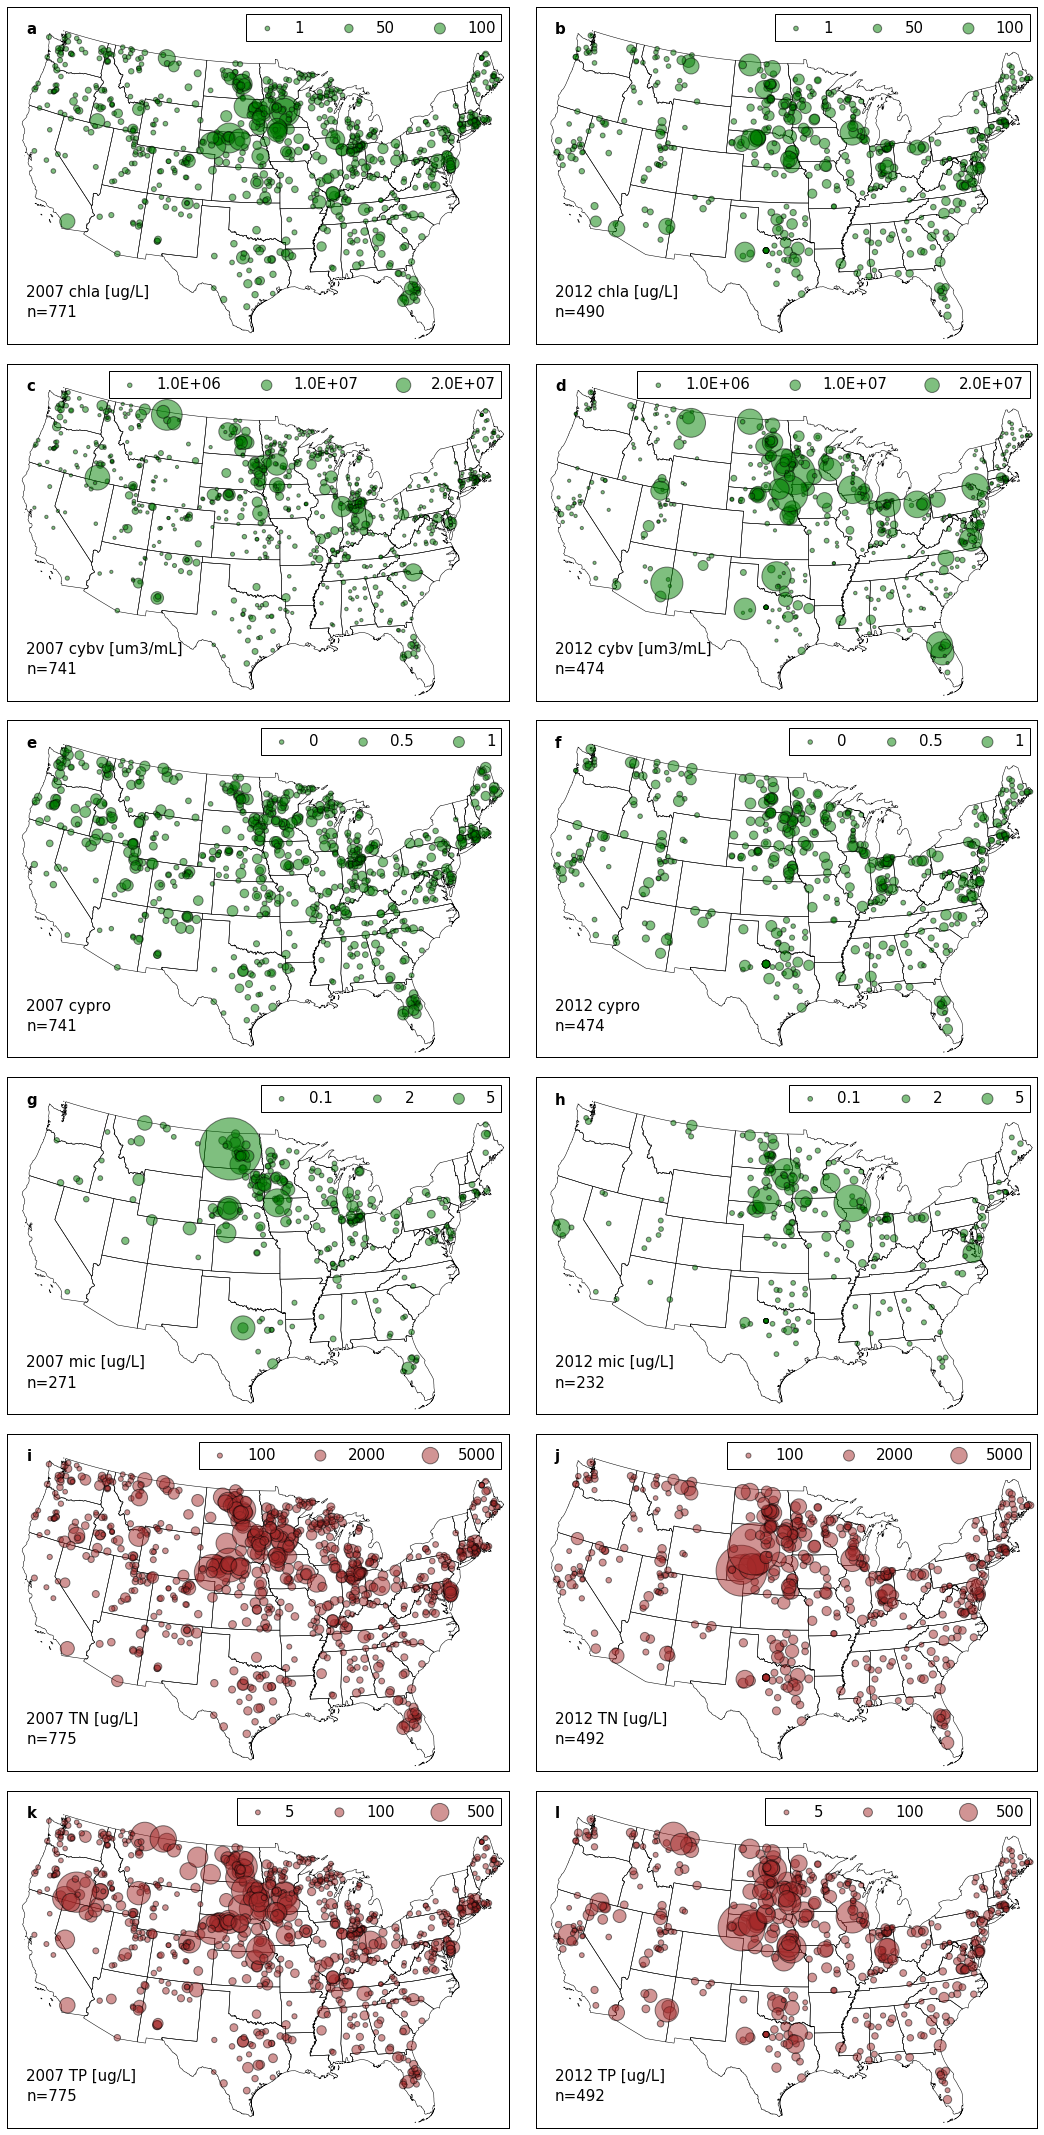

In [39]:
#Fig S1 Locations 07 vs 12

for df in [df_clean,df_mic,df_chla,df_cybv,df_cypro]:
    df.reset_index(inplace=True)
    
fig,ax = plt.subplots(6,2,figsize=(15,30),sharex=True,sharey=True)
plt.tight_layout()
plaxes = [ax[0,0],ax[0,1],ax[1,0],ax[1,1],ax[2,0],ax[2,1],
          ax[3,0],ax[3,1],ax[4,0],ax[4,1],ax[5,0],ax[5,1]]

leg_sizes_list = [[1,50,100],[1e6,1e7,2e7],[0,0.5,1],[0.1,2,5],[100,2000,5000],[5,100,500]]
offsets_b = [20,10,20,20,20,20]
offsets_m = [1,1e-5,100,20,0.05,0.6]
cs=['g','g','g','g','brown','brown']
#duplicate each member in the list for 07 vs 12 comparison on each row:
leg_sizes_list = [val for val in leg_sizes_list for _ in (0,1)]
offsets_b = [val for val in offsets_b for _ in (0,1)]
offsets_m = [val for val in offsets_m for _ in (0,1)]
cs = [val for val in cs for _ in (0,1)]
legnames_short_dupe = [val for val in legnames_short for _ in (0,1)]
k=0
for whichmodel in ['chla','cybv','cypro','mic','tn','tp']:
    for yr in ['2007','2012']:
        df = dict_meta[whichmodel][0]
        if yr=='2007':
            df = df.loc[df['SITE_ID'].str.contains('NLA06608')]
        elif yr=='2012':
            df = df.loc[df['SITE_ID'].str.contains('NLA12')]
        respvar = dict_meta[whichmodel][1]
        if whichmodel=='cypro':
            dispvar = df[respvar]
        else:
            dispvar = np.exp(df[respvar])
        n=len(df)

        # Create basemap and load US states shapefile
        map = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=50.5,
                projection='lcc',lat_1=33,lat_2=45,lon_0=-95)
        map.readshapefile('../USstatesSHP/st99_d00', name='states', drawbounds=True,ax=plaxes[k])

        # Add lon/lat data
        x,y = map(df['lon_dd'].values, df['lat_dd'].values)
        map.scatter(x, y, s=offsets_b[k]+offsets_m[k]*dispvar,
                    c=cs[k],alpha=0.5,
                    label=whichmodel,zorder=10,ax=plaxes[k])

        leg_sizes = leg_sizes_list[k]
        if whichmodel=='cybv':
            leg_sizes_disp = ['{:.1E}'.format(l) for l in leg_sizes]
        else:
            leg_sizes_disp = leg_sizes
        l1 = plaxes[k].scatter([],[], s=offsets_b[k]+offsets_m[k]*leg_sizes[0],c=cs[k],alpha=0.5)
        l2 = plaxes[k].scatter([],[], s=offsets_b[k]+offsets_m[k]*leg_sizes[1],c=cs[k],alpha=0.5)
        l3 = plaxes[k].scatter([],[], s=offsets_b[k]+offsets_m[k]*leg_sizes[2],c=cs[k],alpha=0.5)

        leg = plaxes[k].legend([l1, l2, l3], leg_sizes_disp, ncol=3, frameon=True,# loc=3,
                               fontsize=15)#,title=legnames[k])
        leg.get_title().set_fontsize(15)
        small_x = plaxes[k].get_xlim()[1]*0.03
        small_y_plus = plaxes[k].get_ylim()[1]*0.14
        small_y = plaxes[k].get_ylim()[1]*0.08
        big_y = plaxes[k].get_ylim()[1]*0.92
        plaxes[k].text(small_x,big_y,letters[k],color='k',fontsize=15,fontweight='bold')
        plaxes[k].text(small_x,small_y_plus,'{} {}'.format(yr,legnames_short_dupe[k]),color='k',fontsize=15)
        plaxes[k].text(small_x,small_y,'n={}'.format(n),color='k',fontsize=15)
        k+=1

# plt.savefig('figures_to_look_at/map_07vs12.png',dpi=300)
plt.show()

for df in [df_clean,df_mic,df_chla,df_cybv,df_cypro]:
    df.set_index(['SITE_ID','VISIT_NO'],inplace=True)


chla
[2.4152091658601704, 2.4568021552090951, 2.2822559978679435, 2.2989013080874798, 1.7112085411292401, 2.7377090638738593, 2.1067490062833247]
cybv
[6.9613396818174094, 5.9248143891653857, 8.5546908920275406, 7.3145508144792153, 6.173920946431469, 7.1243395238756575, 6.8168571360151402]
mic
[2.1048572482652119, 2.0470083693315431, 2.0420022519568848, 2.3299076329432875, 1.5271132294757381, 2.2253177758916185, 1.6462089527822181]
tn
[1.1809846200574559, 1.2197643771938, 1.0929176912864993, 1.0716430387680538, 0.83581652401241535, 1.4546977418493261, 0.90225326305826237]
tp
[2.2124509921056594, 2.392330315961376, 1.7065992798589498, 1.859197549485071, 1.4958661596423311, 2.5022007678993776, 1.9267568252016192]


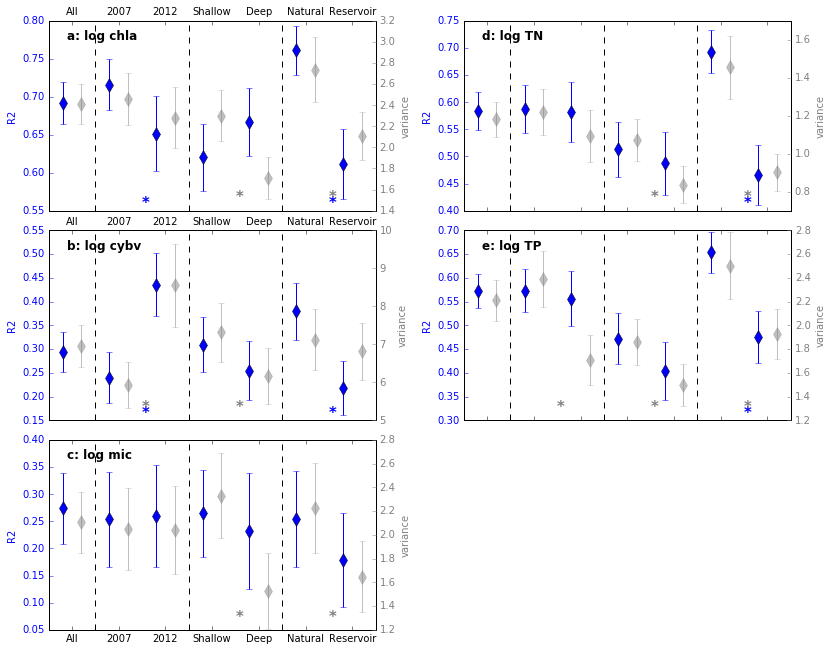

In [6]:
# Fig S3 means and 95% CIs for all vars

# whether to plot mean +/- sem, var +/- se_var, or r2 +/- se_r2
plot_form = 'R2' #mean or var or r2

fig,ax = plt.subplots(3,2,figsize=(11,9),sharex=True)
plt.tight_layout(w_pad=6)
plaxes = [ax[0,0],ax[1,0],ax[2,0],ax[0,1],ax[1,1],ax[2,1]]
k=0
for whichmodel in ['chla','cybv','mic','tn','tp']:
    print(whichmodel)
    df = dict_meta[whichmodel][0]
    n=len(df)

    # getting lake status (natural vs reservoir)
    nla12siteinfo = pd.DataFrame.from_csv('../NLA/nla2012_wide_siteinfo_08232016.csv')
    nla12siteinfo.reset_index(inplace=True)
    nla12siteinfo.set_index(['SITE_ID','VISIT_NO'],inplace=True)
    nla07siteinfo = pd.DataFrame.from_csv('../NLA/nla2007_alldata/NLA2007_SampledLakeInformation_20091113.csv')
    nla07siteinfo.reset_index(inplace=True)
    nla07siteinfo.set_index(['SITE_ID','VISIT_NO'],inplace=True)

    df_lo = pd.DataFrame(nla12siteinfo['LAKE_ORIGIN']).append(pd.DataFrame(nla07siteinfo['LAKE_ORIGIN']))
    df_lo.loc[df_lo['LAKE_ORIGIN']=='MAN-MADE','LAKE_ORIGIN'] = 'MAN_MADE'
    df_lo.loc[df_lo['LAKE_ORIGIN']=='UNCERTAIN','LAKE_ORIGIN'] = np.nan

    #join to df
    df.reset_index(inplace=True)
    df.set_index(['SITE_ID','VISIT_NO'],inplace=True)
    df = df.join(df_lo)
    
    #by natural/manmade!
    df_sub1 = df.loc[df['LAKE_ORIGIN']=='NATURAL']
    df_sub2 = df.loc[df['LAKE_ORIGIN']=='MAN_MADE']
    df_subs_rt = [df_sub1,df_sub2]

    #by depth
    thresh = 6
    df_sub1 = df.loc[df['depth_m_log']<=np.log(thresh)]
    df_sub2 = df.loc[df['depth_m_log']>np.log(thresh)]
    df_subs_depth = [df_sub1,df_sub2]

    #by 07 and 12
    df.reset_index(inplace=True)
    df_sub1 = df.loc[df['SITE_ID'].str.contains('NLA06608')]
    df_sub2 = df.loc[df['SITE_ID'].str.contains('NLA12')]
    for df_i in [df,df_sub1,df_sub2]:
        df_i.set_index(['SITE_ID','VISIT_NO'],inplace=True)
    df_subs_yr = [df_sub1,df_sub2]
    
    #get best_ols_vars as a list
    best_models = pd.DataFrame.from_csv(
        'best_models/best_models_{}_{}_{}.csv'.format(whichmodel,whichyear,suff))
    best_models = best_models.sort_values(by='BIC')
    best_ols_vars = best_models.iloc[0].model
    best_ols_vars = ast.literal_eval(best_ols_vars) #need literal eval because otherwise is str
    best_ols_vars = list(best_ols_vars)
    
    #get regressionresults object
    def get_mod(i_vars,dafr):
        df_i = dafr[[dict_meta[whichmodel][1]]+i_vars].copy()
        y = df_i[dict_meta[whichmodel][1]]
        X = df_i[i_vars]
        X = sm.add_constant(X)
        est = sm.OLS(y,X,missing='raise').fit() 
        return [est,df_i]
    
    [best_ols,best_ols_df] = get_mod(best_ols_vars,df)
    rsq = best_ols.rsquared

    if plot_form=='mean':
        sub_ys = [df[dict_meta[whichmodel][1]].mean()]
        sub_yerrs = [1.96*df[dict_meta[whichmodel][1]].std()/np.sqrt(n)]
    elif plot_form=='var':
        sub_ys = [df[dict_meta[whichmodel][1]].var()]
        sub_yerrs = [1.96*df[dict_meta[whichmodel][1]].var()*np.sqrt(2.0/(n-1))]
    elif plot_form=='R2':
        sub_ys = [rsq]
        sub_yerrs = [1.96*np.sqrt( 4*rsq*((1-rsq)**2)*((n-len(best_ols_vars)-1)**2)/(((n**2)-1)*(n+3)) )]
        sub_y2s = [df[dict_meta[whichmodel][1]].var()]
        sub_y2errs = [1.96*df[dict_meta[whichmodel][1]].var()*np.sqrt(2.0/(n-1))]
    df_sub_i=0
    r2_diffs = []
    var_diffs = []
    for df_subs in [df_subs_yr,df_subs_depth,df_subs_rt]:
        r2s = []
        ser2s = []
        obses = []
        i=0
        for df_sub in df_subs:
            obs = df_sub[dict_meta[whichmodel][1]]
            obses.append(obs)
            n_sub=len(df_sub)
            k_sub = len(best_ols_vars)
            sub_mean = obs.mean()
            sub_std = obs.std()
            sub_var = obs.var()

            [best_ols_sub,best_ols_sub_df] = get_mod(best_ols_vars,df_sub)
            r2 = best_ols_sub.rsquared
            r2s.append(r2)
            ser2 = np.sqrt( 4*r2*((1-r2)**2)*((n_sub-k_sub-1)**2)/(((n_sub**2)-1)*(n_sub+3)) )
            ser2s.append(ser2)
            r2_CI = (r2-1.96*ser2,r2+1.96*ser2)
            
            if plot_form=='mean':
                sub_ys.append(sub_mean)
                sub_yerrs.append(1.96*sub_std/np.sqrt(n_sub))
            elif plot_form=='var':
                sub_ys.append(sub_var)
                sub_yerrs.append(1.96*sub_var*np.sqrt(2.0/(n_sub-1)))
            elif plot_form=='R2':
                sub_ys.append(r2)
                sub_yerrs.append(1.96*ser2)
                sub_y2s.append(sub_var)
                sub_y2errs.append(1.96*sub_var*np.sqrt(2.0/(n_sub-1)))
            i+=1

        #calculate difference in mean response variable values and difference in r2s to see statistical signif
        r2_diff = np.abs(r2s[1]-r2s[0])
        ser2_diff = np.sqrt( ser2s[0]**2 + ser2s[1]**2 )
        r2_diff_CI90 = (r2_diff-1.645*ser2_diff,r2_diff+1.645*ser2_diff)
        r2_diff_CI95 = (r2_diff-1.96*ser2_diff,r2_diff+1.96*ser2_diff)
        r2_diff_CI99 = (r2_diff-2.576*ser2_diff,r2_diff+2.576*ser2_diff)
        if r2_diff_CI95[0]>0:
            r2_diffs.append('*')
        else:
            r2_diffs.append(' ')
        [t, pval] = stats.ttest_ind(obses[0],obses[1],equal_var=False)
        [W, pval] = stats.levene(obses[0],obses[1])
        if pval<0.05:
            var_diffs.append('*')
        else:
            var_diffs.append(' ')
        df_sub_i+=1
    print(sub_y2s)
    
    #primary y-axis
    xes = np.arange(1.0,8.0,1.0)
    plaxes[k].errorbar(xes-0.2,sub_ys,yerr=sub_yerrs,marker='d',ms=10,ls=' ')

    #secondary y-axis
    ax2 = plaxes[k].twinx()
    bg_col = 'grey'
    ax2.errorbar(xes+0.2,sub_y2s,yerr=sub_y2errs,marker='d',ms=10,ls=' ',
                 mfc=bg_col,mec=bg_col,ecolor=bg_col,alpha=0.5)
    ax2.set_ylabel('variance', color=bg_col)
    ax2.tick_params('y', colors=bg_col)
    
    #add vertical lines:
    [ymin,ymax]=plaxes[k].get_ylim()
    [xmin,xmax]=plaxes[k].get_xlim()
    for x_vert in [1.5,3.5,5.5]:
        plaxes[k].plot([x_vert,x_vert],[ymin,ymax],'k--')
    
    #set axes, ticks, etc.
    plaxes[k].axis([xmin,xmax,ymin,ymax])
    plaxes[k].set_xlim([0.5,7.5])
    plaxes[k].set_xticklabels([' ','All','2007','2012','Shallow','Deep','Natural','Reservoir'])
    plaxes[k].tick_params('y', colors='b')
    plaxes[k].set_ylabel(plot_form,color='b')
    
    #add text
    small_x = 0.9
    small_y = ymin+(ymax-ymin)*0.015
    small_y_abv = ymin+(ymax-ymin)*0.045
    big_y = ymin+(ymax-ymin)*0.9
    big_y_blw = ymin+(ymax-ymin)*0.82
    plaxes[k].text(small_x,big_y,'{}: {}'.format(letters[k],modelnames[k]),
                   color='k',fontsize=12,fontweight='bold')
#     plaxes[k].text(small_x,big_y_blw,modelnames[k],color='k',fontsize=12,fontweight='bold')
    #significances
    x_signif = np.arange(2.5,8.5,2)
    for i in range(0,3):
        plaxes[k].text(x_signif[i],small_y,r2_diffs[i],
                       fontsize=15,fontweight='bold',color='b')
        plaxes[k].text(x_signif[i],small_y_abv,var_diffs[i],
                       fontsize=15,fontweight='bold',color=bg_col)
    k+=1

plaxes[5].remove()
for k in [0,1]:
    plaxes[k].xaxis.tick_top() 

# plt.savefig('figures_to_look_at/subset_R2_vs_var_5.png',bbox_inches='tight',dpi=300)
plt.show()